# Referências

**BERTopic:** https://maartengr.github.io/BERTopic/index.html

**Topic Modelling using BERTopic:** https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640 <br>
**Topic Modelling using ChatGPT API:** https://towardsdatascience.com/topic-modelling-using-chatgpt-api-8775b0891d16 <br>
**Topic Modelling in production:** https://towardsdatascience.com/topic-modelling-in-production-e3b3e99e4fca

# Testes a serem feitos

- recuperar os embeddings e analisa-los (visualização dos resultados UMAP)
- Utilizar o método de redução de tópicos (tvz fitar o modelo sem setar o numero de topicos e depois reduzir (?) (model.reduce_topics(docs, nr_topics=60)
- Analisar a similaridade dos tópicos (similar_topics, similarity = model.find_topics("palavra termo a ser analisada", top_n=5); similar_topics
- checar sazonalidade dos dados e se vale a pena usar dynamic topic modeling
- langchain (llm)
- https://maartengr.github.io/BERTopic/faq.html para lidar com com problemas de memória
- data augmentation para agregamento
- testar n_gram_range diferentes (fiz inicialmente (1,2) para testar, mas pode ser (2,3) (1,3), fazer (2,3) e depois simplificar a representação dos topicos para (1,3) topic_model.update_topics(docs, n_gram_range=(1, 3))
- analisar para meu baseline, qual outlier reduction funciona melhor
- testar countvectorizer no lugar do keybert


In [1]:
!pip install bertopic --quiet
!pip install transformers --quiet

In [2]:
import pandas as pd
import numpy as np
from umap import UMAP

In [3]:
from transformers import AutoModel, AutoTokenizer

In [4]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import torch

## Utils

In [6]:
# Função simples, extrai explicitamente o embedding do token [CLS] (outputs.last_hidden_state[:,0,:]) 

# menos eficiente, pois processa os documentos de uma vez e não em batches
# maior uso de memória, pois mantém todos os tensores no formato pytorch até a conversao final para numpy

def bertimbau_embedding(texts):
    embeddings = []
    for text in texts:
        inputs = bertimbau_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = bertimbau_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:,0,:].numpy())
    return embeddings

In [7]:
# Mais eficiente, pois processa os documentos em batches (melhor para grande volume de dados)
# pode ser mais flexível por calcular a média dos embeddings dos tokens para cada documento, o que pode vir a capturar melhor a info distribuida ao longo do documento inteiro
# A média dos embeddings dos tokens pode ou não ser ideal, dependendo do tipo de informação que se deseja capturar dos documentos. Para tarefas que dependem 
# fortemente do contexto inicial do documento (como pode ser indicado pelo token [CLS]), essa abordagem pode diminuir essa especificidade

def get_embeddings(docs, model, tokenizer, batch_size=8):
    model.eval()  # Coloca o modelo em modo de avaliação (desativa camadas específicas como dropout e batch normalization)
    embeddings = []  
    with torch.no_grad():  # Desativa o cálculo de gradientes para economizar memória
        for i in range(0, len(docs), batch_size):
            batch_docs = docs[i:i+batch_size] 
            # Tokeniza o lote de documentos
            encoded_input = tokenizer(batch_docs, return_tensors="pt", padding=True, truncation=True, max_length=512)
            outputs = model(**encoded_input)  # Passa o lote tokenizado pelo modelo
            # Seleciona o embedding do token CLS para cada documento no lote
            batch_embeddings = outputs.last_hidden_state[:,0,:]
            embeddings.append(batch_embeddings)  
    embeddings = torch.cat(embeddings)
    return embeddings.cpu().numpy()

## Read data

In [8]:
df = pd.read_csv('../data/X_test_5.csv')

In [9]:
df.shape

(51552, 2)

In [10]:
df.sample(frac=0.2, random_state=42)

OBS  \
12146  MATERIAL QUIMICO, NECESSARIO QUE O CURSO MOP E...   
29645  Rotas partindo de Itupeva/SP para Campinas/SP ...   
35238  Carregar Pirituba x Guarulhos 07:00 pago 600,0...   
50944                          BAÚ 108M³, 7.449 KG LIVRE   
27670  São duas chapas de aço, livre de carga e desca...   
...                                                  ...   
47906                                           STRONDO.   
38541  CARREGAMENTO IMEDIATO -VEICULO CARRETINHA-  TI...   
26275  Necessário Buonny....1 coleta e entrega...peso...   
36349                          01 entrega em Floriano-PI   
5020   Complemento - 2,44 LARGURA X 6,00 MTS COMPRIME...   

                    DAY_WEEK  
12146  2023-11-13/2023-11-19  
29645  2023-11-27/2023-12-03  
35238  2024-02-05/2024-02-11  
50944  2023-10-30/2023-11-05  
27670  2023-10-02/2023-10-08  
...                      ...  
47906  2024-01-15/2024-01-21  
38541  2023-11-20/2023-11-26  
26275  2023-11-06/2023-11-12  
36349  2023-10-23/2023-10-29  
5020   2023-11-20/2023-11-26  

[10310 rows x 2 columns]

In [11]:
df = df.sample(frac=0.5, random_state=42)

In [12]:
df.shape

(25776, 2)

### Definindo docs

In [13]:
docs = df['OBS'].tolist()

### Usando KeyBERT

In [14]:
representation_model = KeyBERTInspired()

## Instanciando os modelos

In [15]:
model_name = "neuralmind/bert-base-portuguese-cased"
bertimbau_model = AutoModel.from_pretrained(model_name)
bertimbau_tokenizer = AutoTokenizer.from_pretrained(model_name)

## Topic Modeling

In [37]:
# Instanciar o BERTopic com a função de embedding personalizada (bertimbau_embedding)
topic_model = BERTopic(representation_model=representation_model,
                       embedding_model=bertimbau_embedding,
                       calculate_probabilities=True,
                       n_gram_range=(1, 2),
                       nr_topics=20)

In [42]:
topics, probabilities = topic_model.fit_transform(docs)
# topics, probabilities = topic_model.fit_transform(docs, embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### Topic embeddings

O atributo **topic_embeddings_** no BERTopic, após o treinamento, representa os embeddings de cada tópico identificado. Esses embeddings são tipicamente calculados como o centroide (média) dos embeddings de todos os documentos associados a um tópico específico. 
Eu estranhei que len(raw_embeddings) é igual a 20, mas isso indica que o modelo identificou 20 tópicos distintos dentro dos dados (**nr_topics=20**), e, para cada tópico, calculou um embedding representativo baseado nos documentos que foram agrupados sob esse tópico.

In [19]:
raw_embeddings = topic_model.topic_embeddings_

In [40]:
len(raw_embeddings)

20

## raw topic_model

Top 10 termos de um tópico

In [43]:
topic_model.get_topic(1)

[('ou conectcar', 0.6103994),
 ('estado tag', 0.58221096),
 ('bom estado', 0.4927724),
 ('parar ou', 0.4882675),
 ('ton necessario', 0.44112942),
 ('necessario tag', 0.43242338),
 ('estado', 0.4323468),
 ('conectcar', 0.4162343),
 ('buonny tag', 0.4122184),
 ('carregamento', 0.40783948)]

#### Visualizando as top palavras por tópico

In [44]:
topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1  10694        -1_de carga_carga descarga_descarga_entrega   
1       0  13086           0_de carga_carga descarga_descarga_carga   
2       1    576      1_ou conectcar_estado tag_bom estado_parar ou   
3       2    470                2_kg volumes_kg volume_volume_kg m³   
4       3    229   3_pallets_pallets pallet_pallets peso_12 pallets   
5       4    184  4_coleta imediata_imediata coleta_coleta_colet...   
6       5    116  5_complemento medidas_largura comprimento_altu...   
7       6    100     6_carreta 14_mts carreta_mt carreta_carreta 13   
8       7     96  7_metros cubicos_metros cúbicos_cubicos metros...   
9       8     75  8_caixas apenas_apenas caixas_caixa apenas_cai...   
10      9     23  9_na cargill_cargill carrega_cargill de_coasa ...   
11     10     22              10_28ton_28ton 15_20pl 28ton_28ton 37   
12     11     15  11_seguradora krona_krona seguradora_krona ou_...   
13     12     14  12_academia que_de academia_academia são_acade...   
14     13     14  13_quarta carregamento_carregamento 09_carrega...   
15     14     13                 14_ton lcd_lcd 35_32ton lcd_lcd 50   
16     15     13             15_obs peso_ou china_china obs_ter 80m   
17     16     12   16_faz santa_santa rita_santa terezinha_rita faz   
18     17     12        17_obs valor_mundo obs_novo mundo_valor 400   
19     18     12  18_maderite sider_maderites sider_sider necess...   

                                       Representation  \
0   [de carga, carga descarga, descarga, entrega, ...   
1   [de carga, carga descarga, descarga, carga, en...   
2   [ou conectcar, estado tag, bom estado, parar o...   
3   [kg volumes, kg volume, volume, kg m³, volumes...   
4   [pallets, pallets pallet, pallets peso, 12 pal...   
5   [coleta imediata, imediata coleta, coleta, col...   
6   [complemento medidas, largura comprimento, alt...   
7   [carreta 14, mts carreta, mt carreta, carreta ...   
8   [metros cubicos, metros cúbicos, cubicos metro...   
9   [caixas apenas, apenas caixas, caixa apenas, c...   
10  [na cargill, cargill carrega, cargill de, coas...   
11  [28ton, 28ton 15, 20pl 28ton, 28ton 37, 30tons...   
12  [seguradora krona, krona seguradora, krona ou,...   
13  [academia que, de academia, academia são, acad...   
14  [quarta carregamento, carregamento 09, carrega...   
15  [ton lcd, lcd 35, 32ton lcd, lcd 50, lcd 25, 5...   
16  [obs peso, ou china, china obs, ter 80m, 80m o...   
17  [faz santa, santa rita, santa terezinha, rita ...   
18  [obs valor, mundo obs, novo mundo, valor 400, ...   
19  [maderite sider, maderites sider, sider necess...   

                                  Representative_Docs  
0   [CARREGAMENTO IMEDIATO - PESO 18 A 20 TON - PA...  
1   [Peso 9 tons, Livre de carga e descarga., Fret...  
2   [CARREGAMENTO AMANHA 11/10/2023 / 27 TON / NEC...  
3   [100 KG    1 VOLUME, 5 KG     1 VOLUME, 50 kg ...  
4   [2 CARGAS PARA O CLIENTE SENDAS DE ARUJA/SP CO...  
5   [Coleta IMEDIATA, COLETA IMEDIATA., COLETA IME...  
6   [- COMPLEMENTO \n- MEDIDAS: 2,30 LARGURA X 1,2...  
7   [Carreta de 14 mt., carreta acima de 14 mts, C...  
8   [13 metros cúbicos, 30 metros cúbicos, 3 metro...  
9   [22 caixas - 800 kg\n3 caixas - 70 kg \nCOLETA...  
10  [Carregar na Cargill em Rio Verde - GO e desca...  
11  [30tons 28pallets., Extensiva  24mts, 20PL 28TON]  
12  [SEGURADORA  PAMCARY  OU  KRONA  \nNESCESSARIO...  
13  [COMPLEMENTO 1 APARELHO DE ACADEMIA, 2 aparelh...  
14  [Carregamento 29/11 - quarta*\nCarregamento 29...  
15             [50 TON LCD, 25 TON LCD, +-20 ton lcd]  
16  [SEGURADORA BOUNNY ADIANTAMENTO DE 80%  OBS O ...  
17  [FAZ. .SANTA LUCIA  X COLINAS - TO, FAZ. SANTA...  
18  [OBS... VALOR R$400,00 | 500KG | 25 VOL | CARR...  
19  [sider necessario maderites, se for sider é ne...

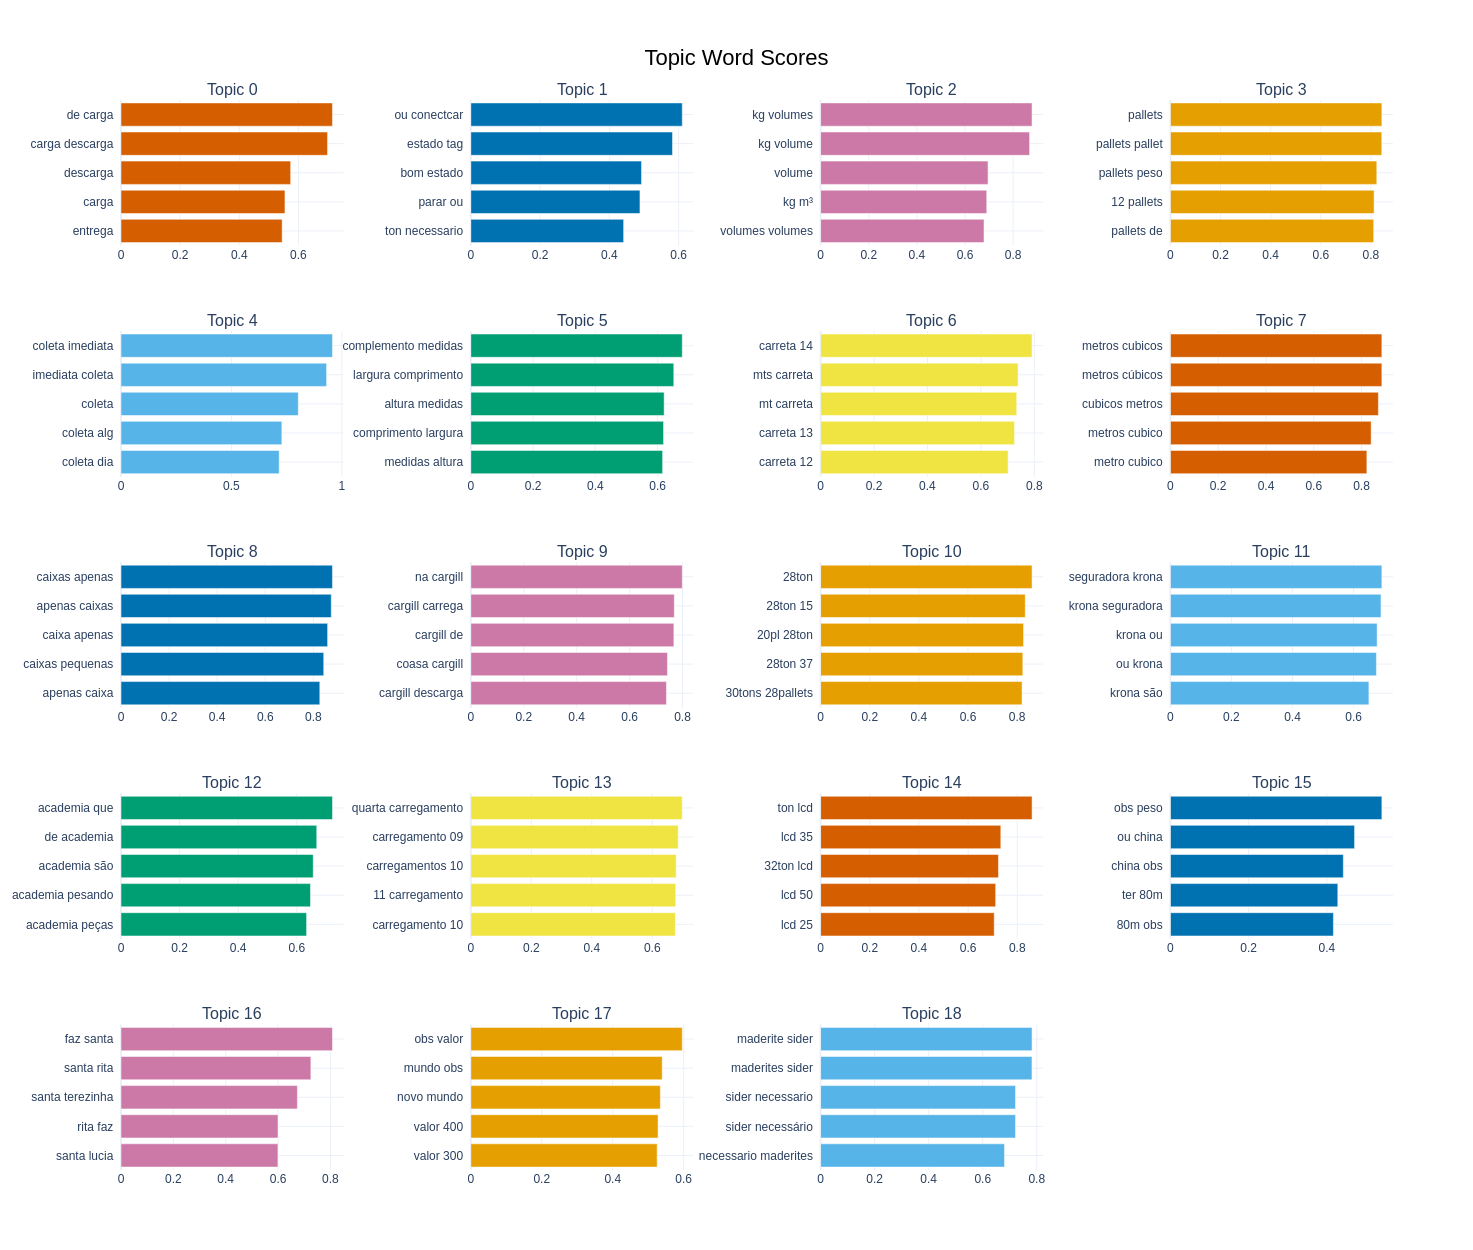

In [45]:
topic_model.visualize_barchart(top_n_topics=20)

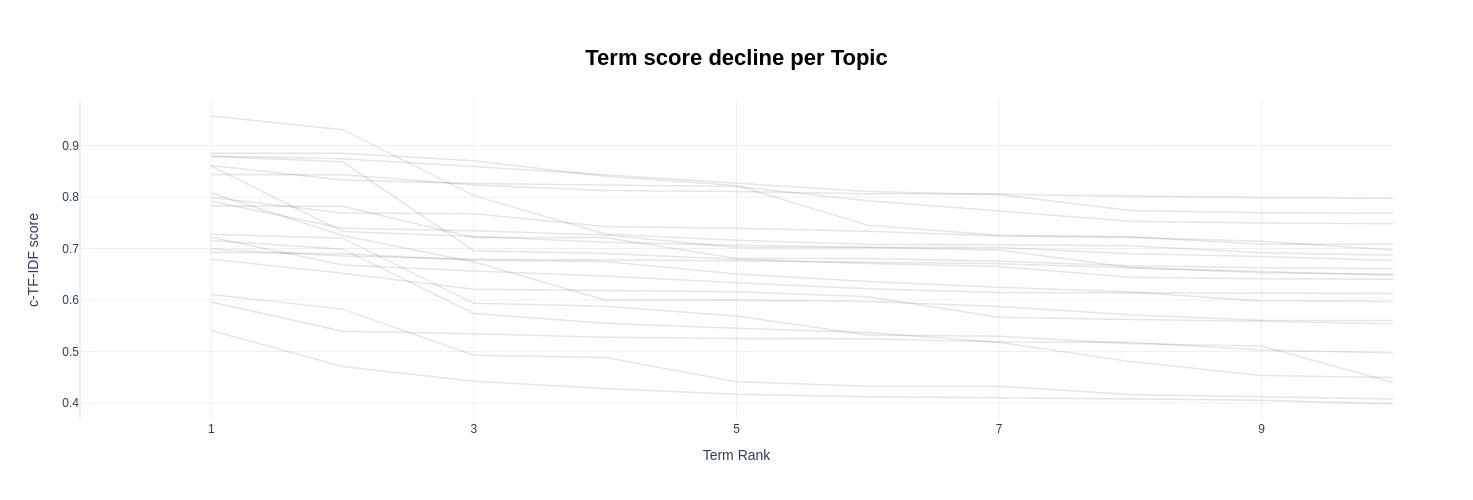

In [46]:
topic_model.visualize_term_rank()

#### Visualizando a distância entre os tópicos

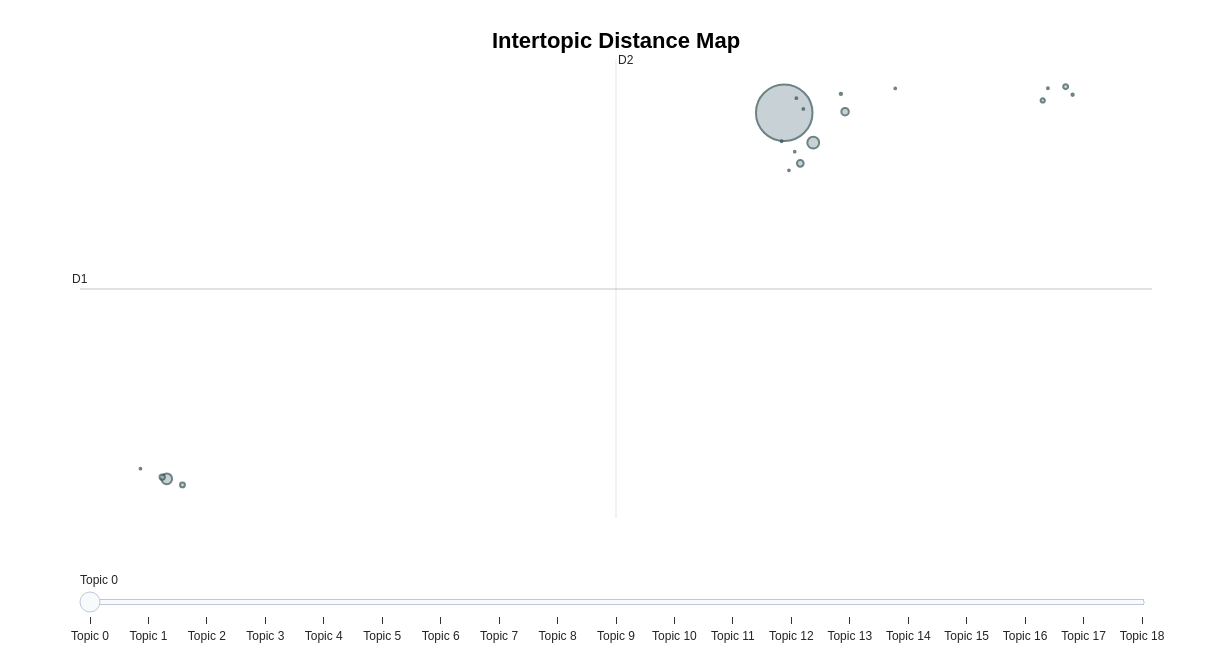

In [47]:
topic_model.visualize_topics()

#### Vizualiando as conexões entre os tópicos

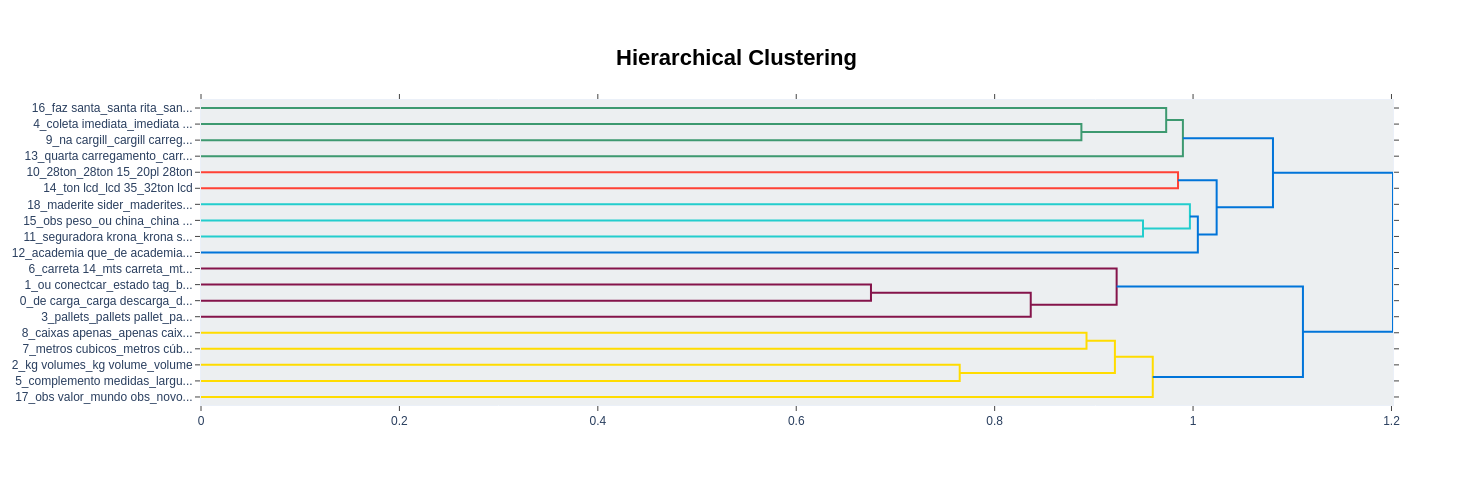

In [48]:
topic_model.visualize_hierarchy(top_n_topics=20)

#### Matrix de similaridade usando heatmap

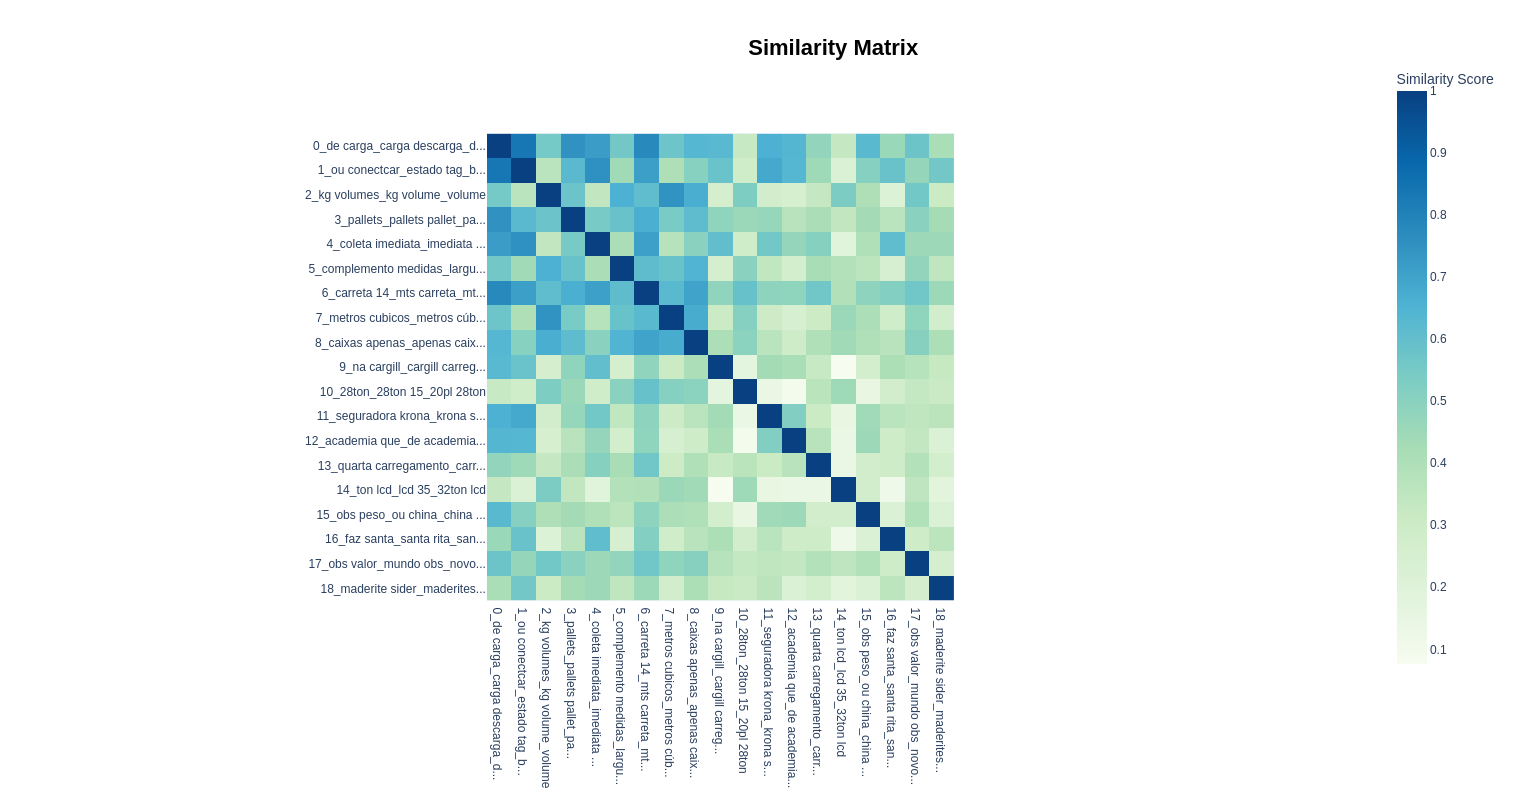

In [49]:
topic_model.visualize_heatmap()

## Reduzindo outliers

In [50]:
strategies = ['probabilities', 'distributions', 'c-tf-idf', 'embeddings']

### probabilities

In [51]:
temp_topic_model = BERTopic(representation_model=representation_model,
                                embedding_model=bertimbau_embedding,
                                calculate_probabilities=True,
                                n_gram_range=(1, 2),
                                nr_topics=20)

In [52]:
temp_topics, temp_probabilities = temp_topic_model.fit_transform(docs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [53]:
new_topics = temp_topic_model.reduce_outliers(docs, temp_topics, probabilities=temp_probabilities, strategy='probabilities')

In [54]:
temp_topic_model.update_topics(docs, topics=new_topics)

2024-02-28 14:47:38,255 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


#### Visualizando as top palavras por tópico

In [55]:
temp_topic_model.get_topic_info()

Topic  Count                                               Name  \
0       0  22906                             0_de_carga_descarga_em   
1       1   1154                           1_paletes_de_carga_livre   
2       2    853                        2_coleta_em_coletar_entrega   
3       3    269                        3_volumes_medidas_volume_kg   
4       4    181                          4_ton_pallets_tons_pallet   
5       5    119                      5_tag_parar_sem parar_tag sem   
6       6     47            6_caixas_caixa_pequenas_caixas pequenas   
7       7     44                                   7_obs_40_20x1_60   
8       8     34                          8_baú_bau_baú de_de 105m3   
9       9     26   9_28ton_32 40m3_extensiva 24mts_disponiveis 55m³   
10     10     24                     10_6x8_6x8 10_lonas_minimo 6x8   
11     11     23    11_cargill_na cargill_descarga cargill_local de   
12     12     17  12_contagem_entregas contagem_em contagem_entr...   
13     13     15          13_pedagio_00_pedagio 200_pedágio entrega   
14     14     15                         14_lcd_ton lcd_ton_kgs lcd   
15     15     13          15_carregamento_quarta carregamento_10_11   
16     16     13                   16_china_pra eraldo_ou china_obs   
17     17     12         17_maderites_maderite sider_sider_maderite   
18     18     11                  18_faz santa_santa_faz_coleta faz   

                                       Representation  \
0   [de, carga, descarga, em, livre, livre de, car...   
1   [paletes, de, carga, livre, 28 paletes, descar...   
2   [coleta, em, coletar, entrega, coleta em, prec...   
3   [volumes, medidas, volume, kg, largura, altura...   
4   [ton, pallets, tons, pallet, ton abaixo, abaix...   
5   [tag, parar, sem parar, tag sem, sem, buonny t...   
6   [caixas, caixa, pequenas, caixas pequenas, cai...   
7   [obs, 40, 20x1, 60, 20, 50, 90, 94, 50 obs, vo...   
8   [baú, bau, baú de, de 105m3, 105m3, baú 10, de...   
9   [28ton, 32 40m3, extensiva 24mts, disponiveis ...   
10  [6x8, 6x8 10, lonas, minimo 6x8, necessário, 1...   
11  [cargill, na cargill, descarga cargill, local ...   
12  [contagem, entregas contagem, em contagem, ent...   
13  [pedagio, 00, pedagio 200, pedágio entrega, 00...   
14  [lcd, ton lcd, ton, kgs lcd, lcd 14, lcd 32, t...   
15  [carregamento, quarta carregamento, 10, 11, ca...   
16  [china, pra eraldo, ou china, obs, eraldo ou, ...   
17  [maderites, maderite sider, sider, maderite, s...   
18  [faz santa, santa, faz, coleta faz, to faz, sa...   

                                  Representative_Docs  
0   [LIVRE DE CARGA E DESCARGA ADIANTAMENTO DE 80%...  
1   [14 paletes livre de carga e descarga 14 ton, ...  
2   [COLETA HOJE E ENTREGA AMANHÃ, PRECISA TER RAS...  
3   [50 kg    1 volume, 1 Volume medidas: 1,50 X 2...  
4                [7- TON ABAIXO  -, 2,5 ton, 2,1 TON]  
5   [+ Pedágio no TAG sem parar., CARREGAMENTO LIB...  
6   [COMPLEMENTO - 2 CAIXAS PEQUENAS, 3 caixas peq...  
7   [OBS!\n02 - VOLUMES DE:\n0,40 X 1,00 X 1,20M\n...  
8   [Baú de 105m3  ou MAIOR, Baú de 11 m x 3, Baú ...  
9   [30tons 28pallets., Extensiva  24mts, 20PL 28TON]  
10  [NECESSARIO 2 LOJAS, MINIMO 6X8, LONIL OU ENCE...  
11  [Carregar na Cargill em Rio Verde - GO e desca...  
12  [2 entregas  contagem - santa luzia, 2 ENTREGA...  
13  [FRETE- R$- 5.500,00 + PEDAGIO-  SOMENTE SIDER...  
14             [50 TON LCD, 25 TON LCD, +-20 ton lcd]  
15  [Carregamento 29/11 - quarta*\nCarregamento 29...  
16  [SEGURADORA BOUNNY ADIANTAMENTO DE 80%  OBS O ...  
17  [sider necessario maderites, se for sider é ne...  
18  [FAZ.SANTA TEREZINHA, coleta faz santa terezin...

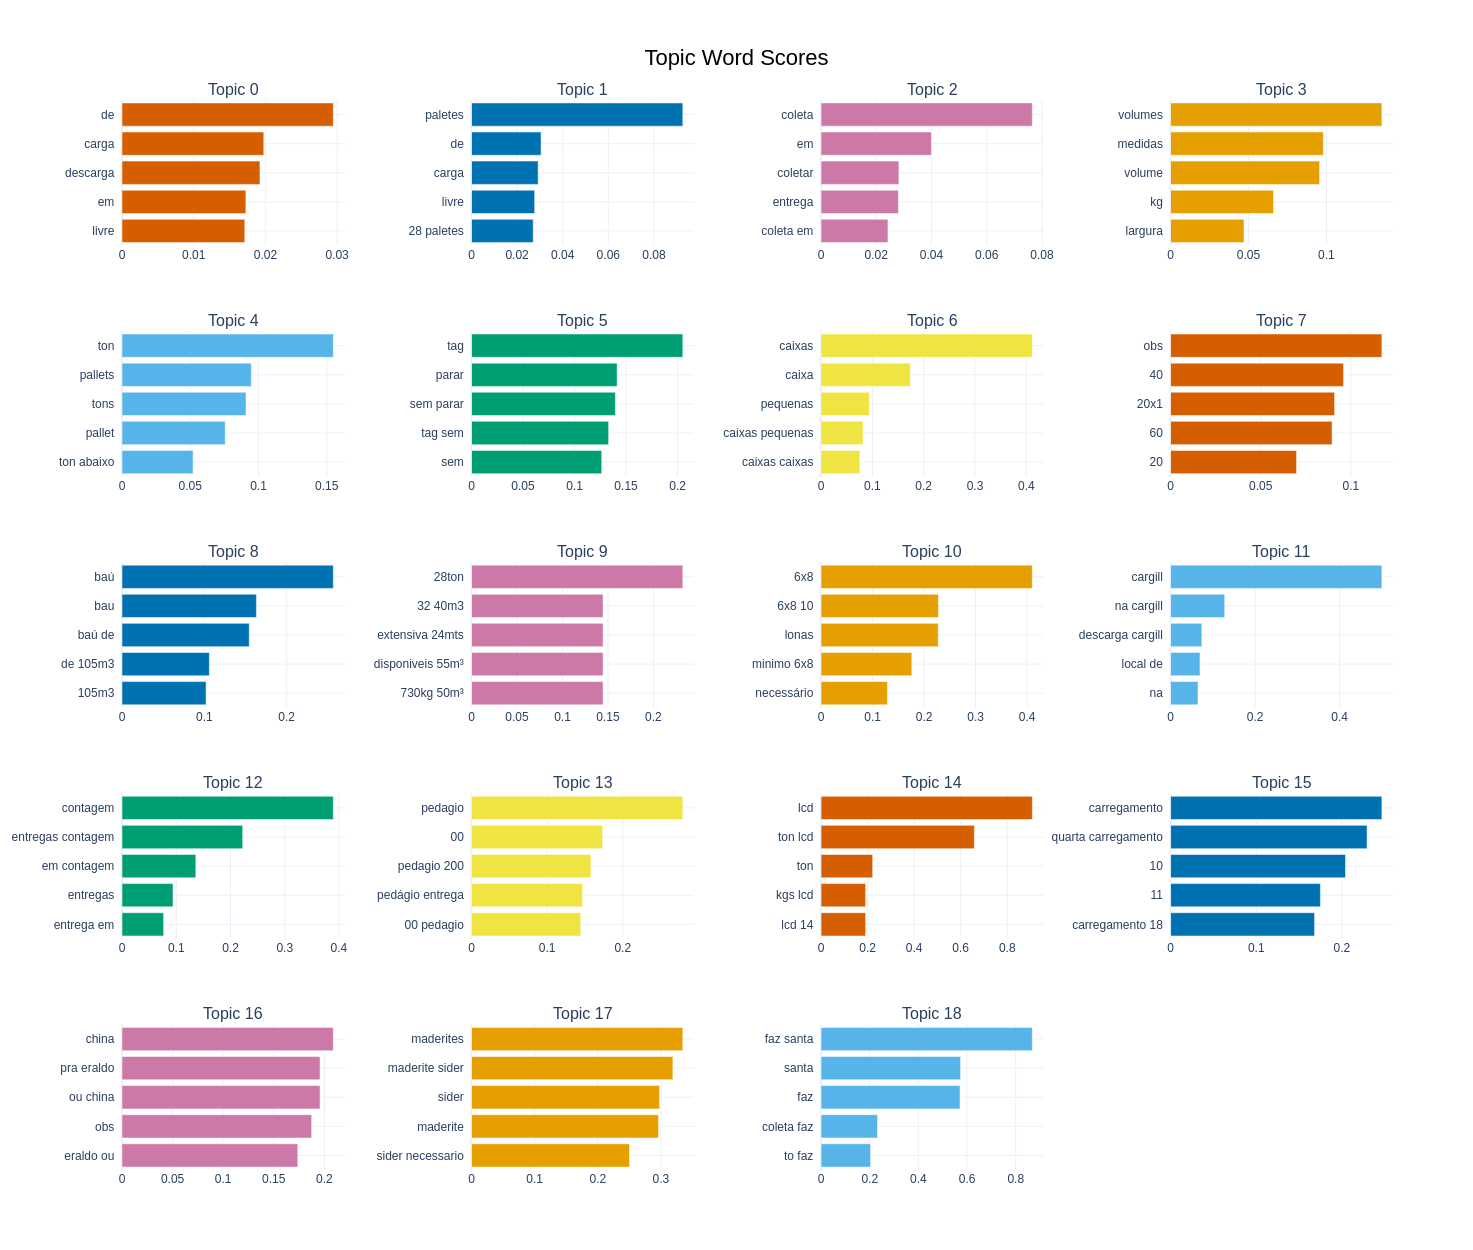

In [56]:
temp_topic_model.visualize_barchart(top_n_topics=20)


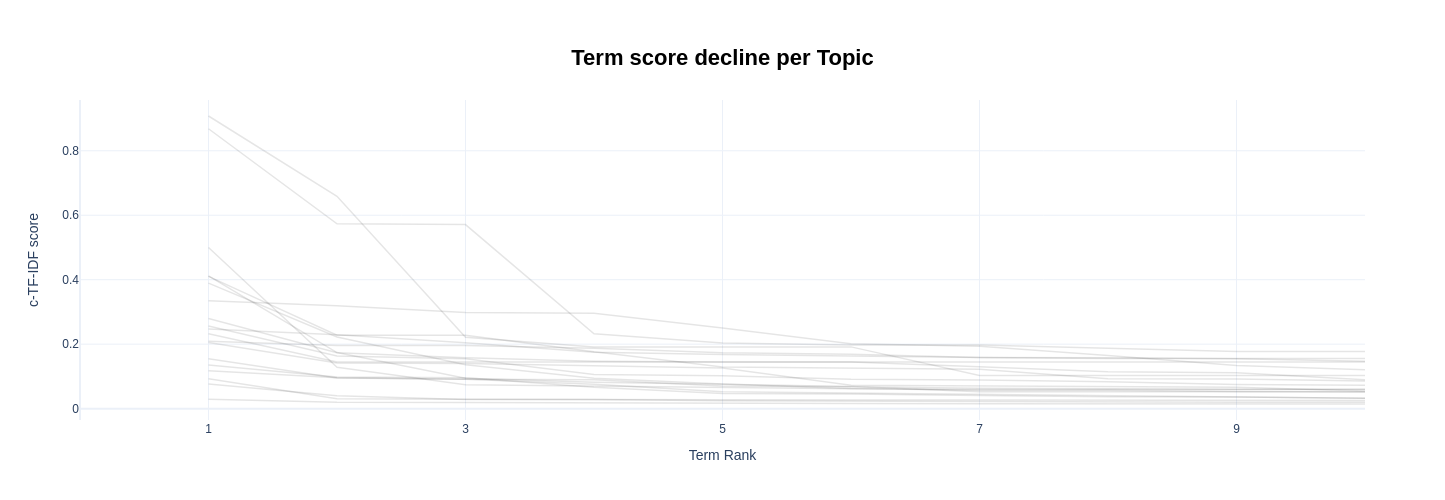

In [57]:
temp_topic_model.visualize_term_rank()

#### Visualizando a distância entre os tópicos

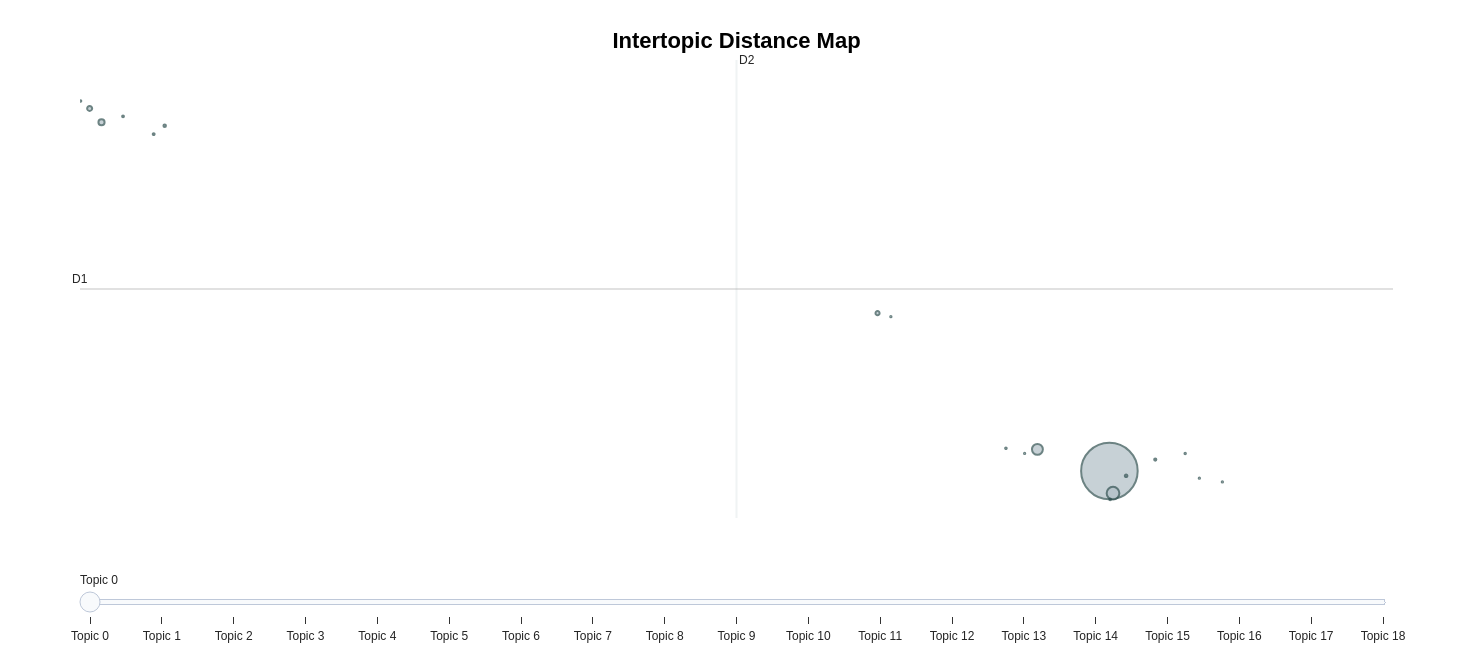

In [58]:
temp_topic_model.visualize_topics()

#### Vizualiando as conexões entre os tópicos

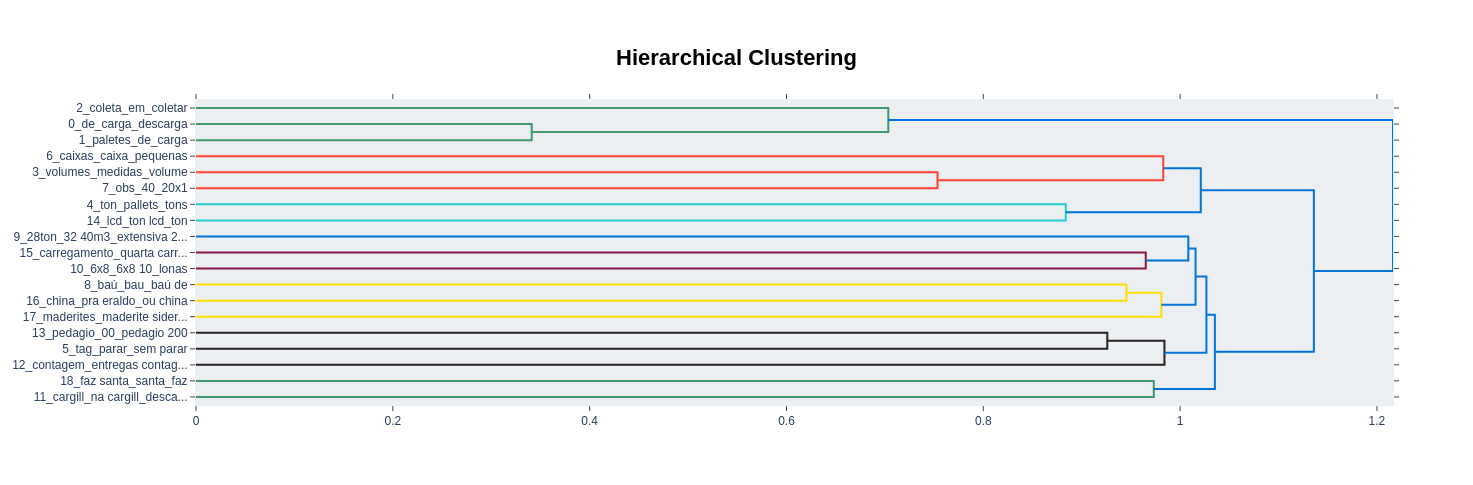

In [59]:
temp_topic_model.visualize_hierarchy(top_n_topics=20)

#### Matrix de similaridade usando heatmap

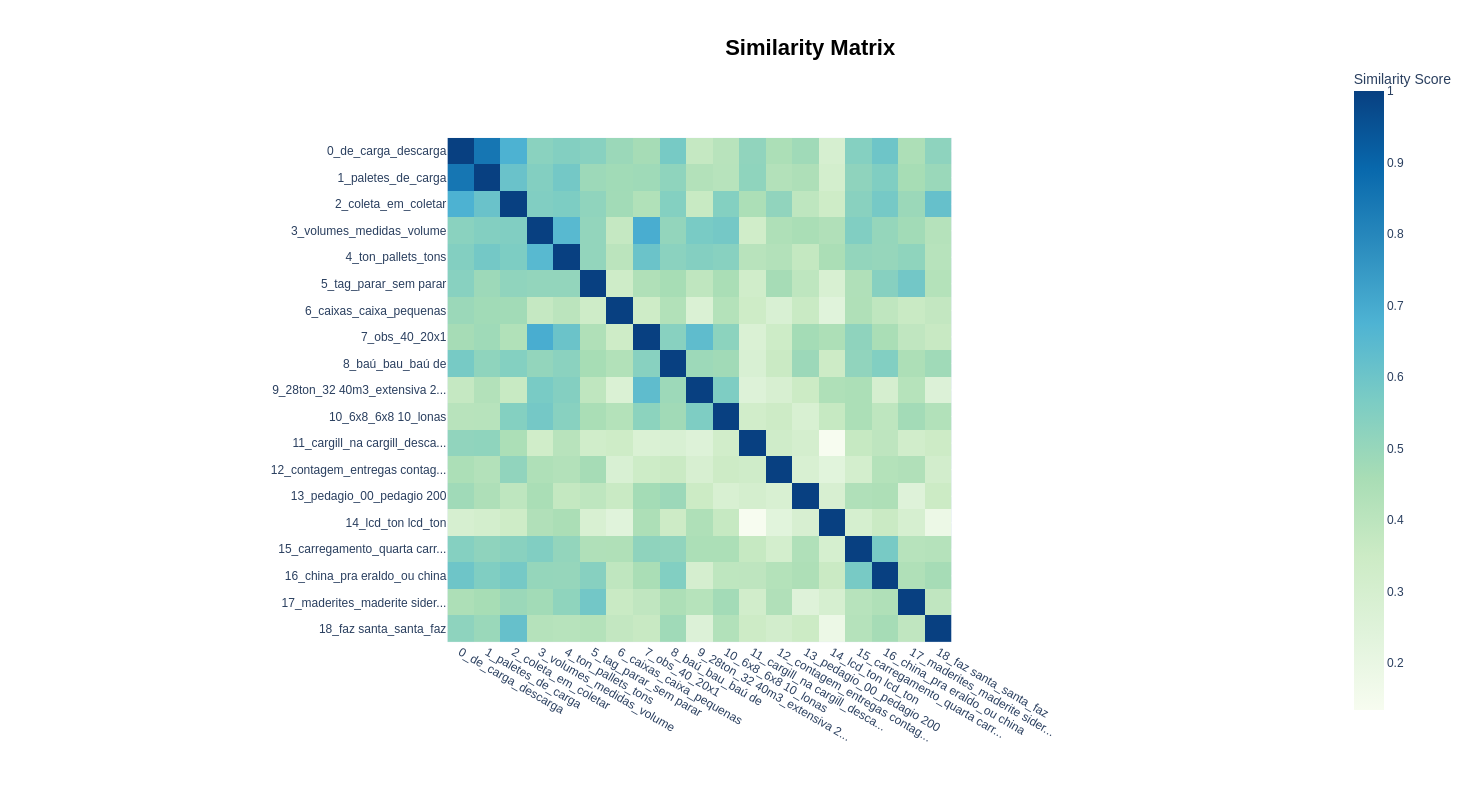

In [60]:
temp_topic_model.visualize_heatmap()

In [61]:
topic_info = temp_topic_model.get_topic_info()

In [62]:
topic_info.to_csv('topic_info_probabilities.csv', index=False)

In [63]:
pd.DataFrame({"Document": docs, "Topic": new_topics}).to_csv('topic_probabilities.csv', index=False)

### distributions

In [64]:
temp_topics, temp_probabilities = temp_topic_model.fit_transform(docs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [65]:
new_topics = temp_topic_model.reduce_outliers(docs, temp_topics, strategy='distributions')

In [66]:
temp_topic_model.update_topics(docs, topics=new_topics)

2024-02-28 14:56:14,854 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


#### Visualizando as top palavras por tópico

In [67]:
temp_topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1     23  -1_102x93x302_boqueirão 102x93x302_casarim_cas...   
1       0  17749                          0_de_carga_descarga_livre   
2       1   1606                              1_paletes_28_de_carga   
3       2   1116                             2_kg_altura_cm_largura   
4       3    891                              3_precisa_dia_faz_kit   
5       4   1266                     4_coleta_em_entrega_entrega em   
6       5    680                                    5_kg_500_vol_00   
7       6    688                          6_ton_tons_abaixo_pallets   
8       7    374                          7_tag_parar_sem parar_sem   
9       8    239                      8_volumes_volume_kg_kg volume   
10      9    239                  9_caixas_caixa_caixas de_caixa de   
11     10    177                                10_60_40_20_medidas   
12     11    103                              11_tn_00_pedagio_peso   
13     12     32                 12_12 40mts_40mts_40tons_extensiva   
14     13     97                   13_forro_seguradora_pamcary_lona   
15     14    138                       14_carregamento_10_11_quarta   
16     15     23                      15_lcd_ton lcd_ton_abaixo lcd   
17     16    113                             16_obs_tem que_que_tem   
18     17    126                        17_mundo_pq_novo_novo mundo   
19     18     96                      18_sider_maderites_for_se for   

                                       Representation  \
0   [102x93x302, boqueirão 102x93x302, casarim, ca...   
1   [de, carga, descarga, livre, livre de, carga d...   
2   [paletes, 28, de, carga, 28 paletes, livre, de...   
3   [kg, altura, cm, largura, comprimento, medidas...   
4   [precisa, dia, faz, kit, precisa de, com, mopp...   
5   [coleta, em, entrega, entrega em, uma, coleta ...   
6   [kg, 500, vol, 00, buonny, valor do, 500 kg, v...   
7   [ton, tons, abaixo, pallets, ton abaixo, palle...   
8   [tag, parar, sem parar, sem, tag sem, parar ou...   
9   [volumes, volume, kg, kg volume, kg volumes, p...   
10  [caixas, caixa, caixas de, caixa de, kg, de, p...   
11   [60, 40, 20, medidas, 00, 90, 50, 80, 20x1, obs]   
12  [tn, 00, pedagio, peso, frete, peso tn, 500 00...   
13  [12 40mts, 40mts, 40tons, extensiva, 3t, 28ton...   
14  [forro, seguradora, pamcary, lona, de forro, l...   
15  [carregamento, 10, 11, quarta, 18, quarta carr...   
16  [lcd, ton lcd, ton, abaixo lcd, 14 500kg, kgs ...   
17  [obs, tem que, que, tem, pra, que ter, china, ...   
18  [mundo, pq, novo, novo mundo, pq novo, no pq, ...   
19  [sider, maderites, for, se for, se, ter, for s...   

                                  Representative_Docs  
0   [CARGA COM 28 PALETES , PESO 4 ABAIXO , CARREG...  
1   [livre de carga e descarga \nLivre de pedágios...  
2   [6,3 ton 12 paletes / livre de carga e descarg...  
3   [CUBAGEM: 5,09 METROS CUBICOS\n16 VOLUMES\nMED...  
4   [Precisa ter Curso MOOP!, Descarga agendada pa...  
5   [1 COLETA EM GUARULHOS-SP e 1 COLETA NA VILA J...  
6   [BUONNY * 1 VOLUME * 50 KG * CUBAGEM : 1,47M³ ...  
7                [7- TON ABAIXO  -, 2,5 ton, 2,1 TON]  
8   [+ Pedágio no TAG sem parar., CARREGAMENTO LIB...  
9   [50 kg 2 volumes, 3 volumes -, 300 kg   6 volu...  
10  [COMPLEMENTO - 2 CAIXAS PEQUENAS, 3 caixas peq...  
11  [OBS!\n02 - VOLUMES DE:\n0,40 X 1,00 X 1,20M\n...  
12    [peso 9 tn - 3 entregas., PESO 7 TN, Peso 3 tn]  
13  [30tons 28pallets., Extensiva  24mts, 20PL 28TON]  
14  [SEGURADORA  PAMCARY  OU  KRONA  \nNESCESSARIO...  
15  [Carregamento 29/11 - quarta*\nCarregamento 29...  
16             [50 TON LCD, 25 TON LCD, +-20 ton lcd]  
17  [SEGURADORA BOUNNY ADIANTAMENTO DE 80%  OBS O ...  
18  [OBS... VALOR R$400,00 | 500KG | 25 VOL | CARR...  
19  [sider necessario maderites, se for sider é ne...

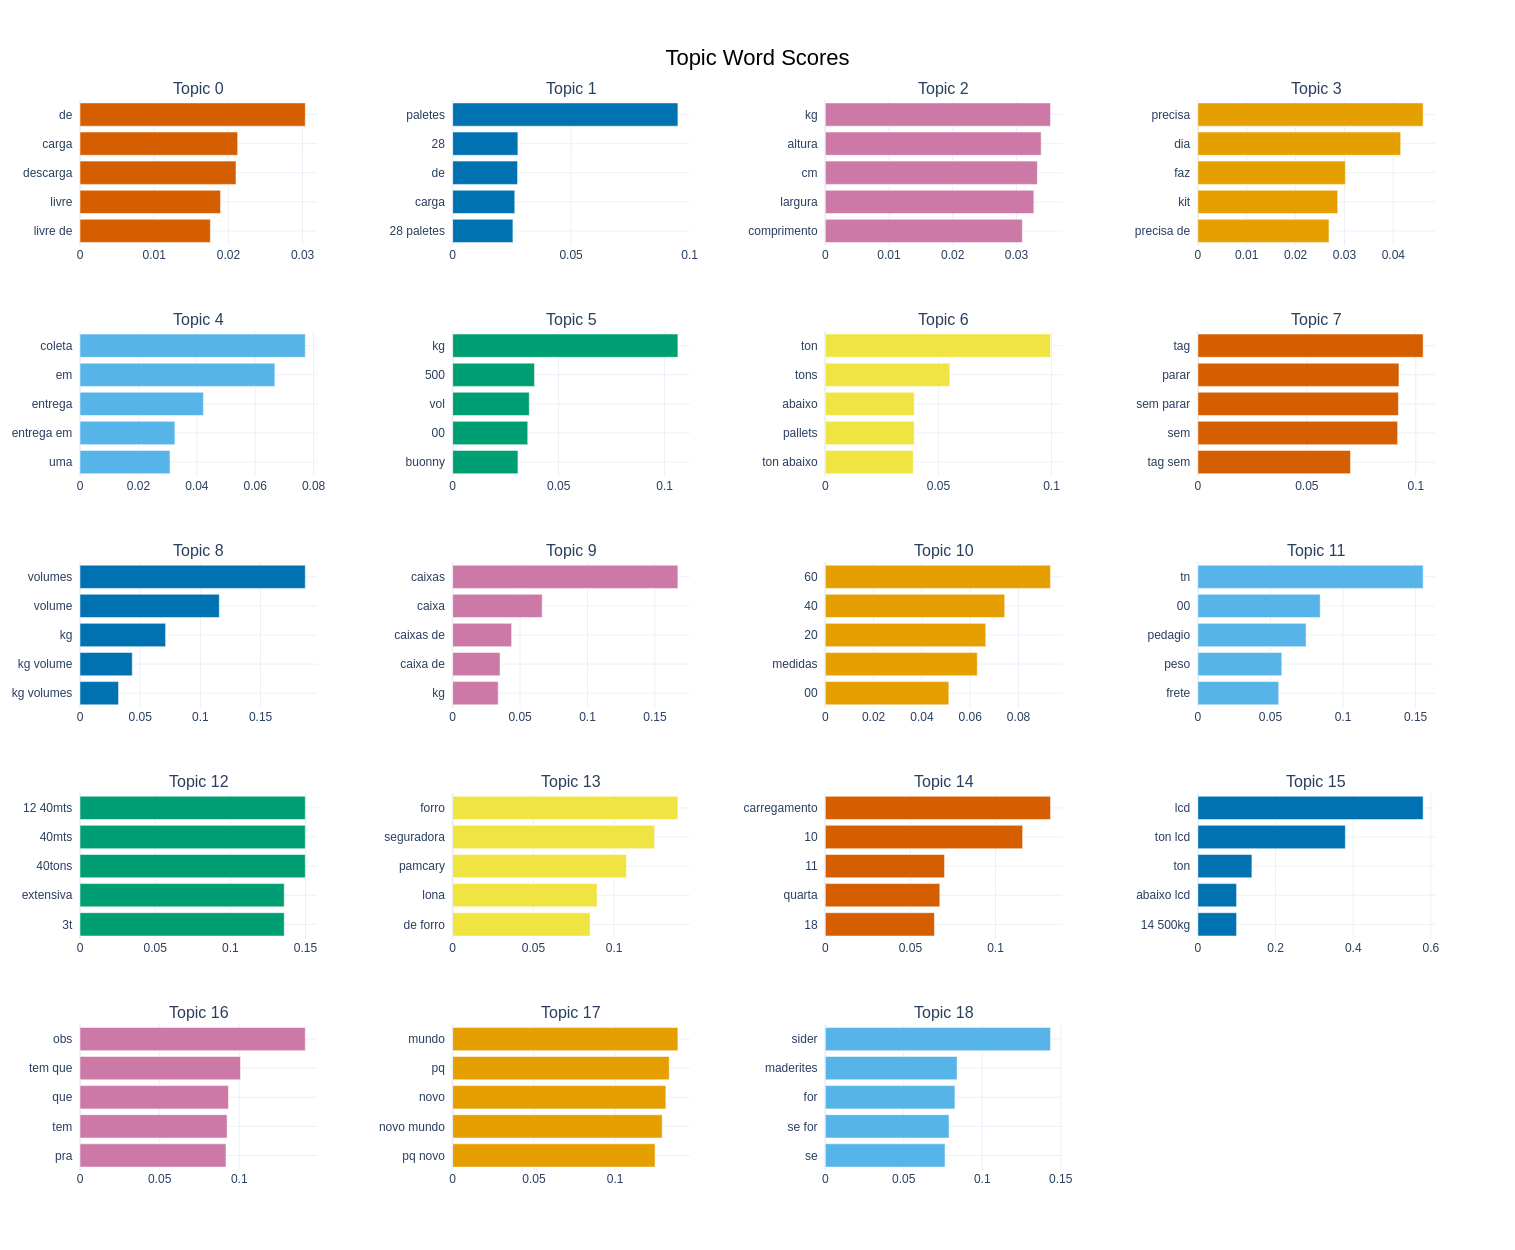

In [68]:
temp_topic_model.visualize_barchart(top_n_topics=20)


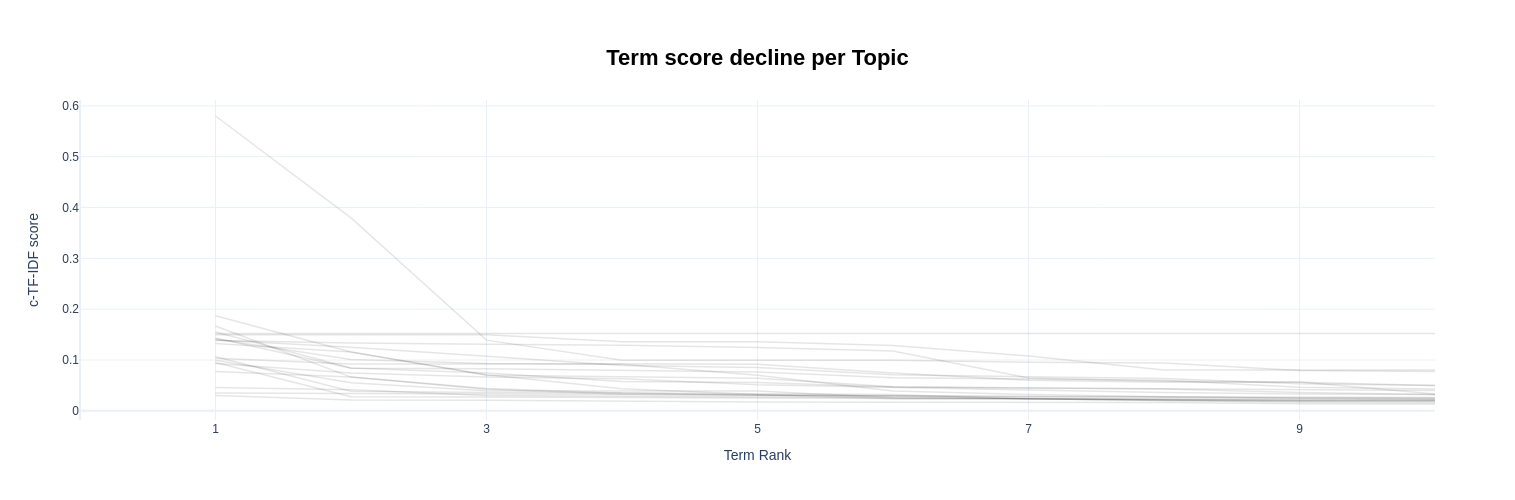

In [69]:
temp_topic_model.visualize_term_rank()

#### Visualizando a distância entre os tópicos

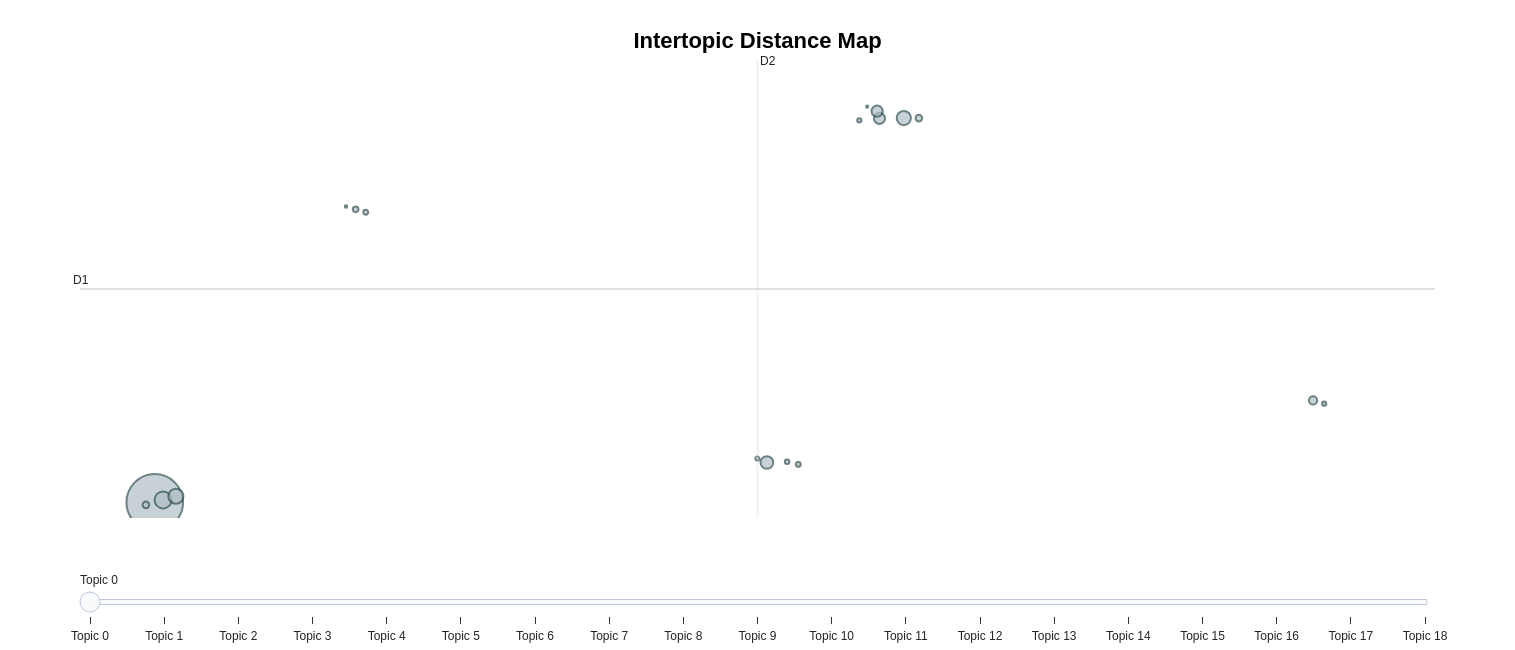

In [70]:
temp_topic_model.visualize_topics()

#### Vizualiando as conexões entre os tópicos

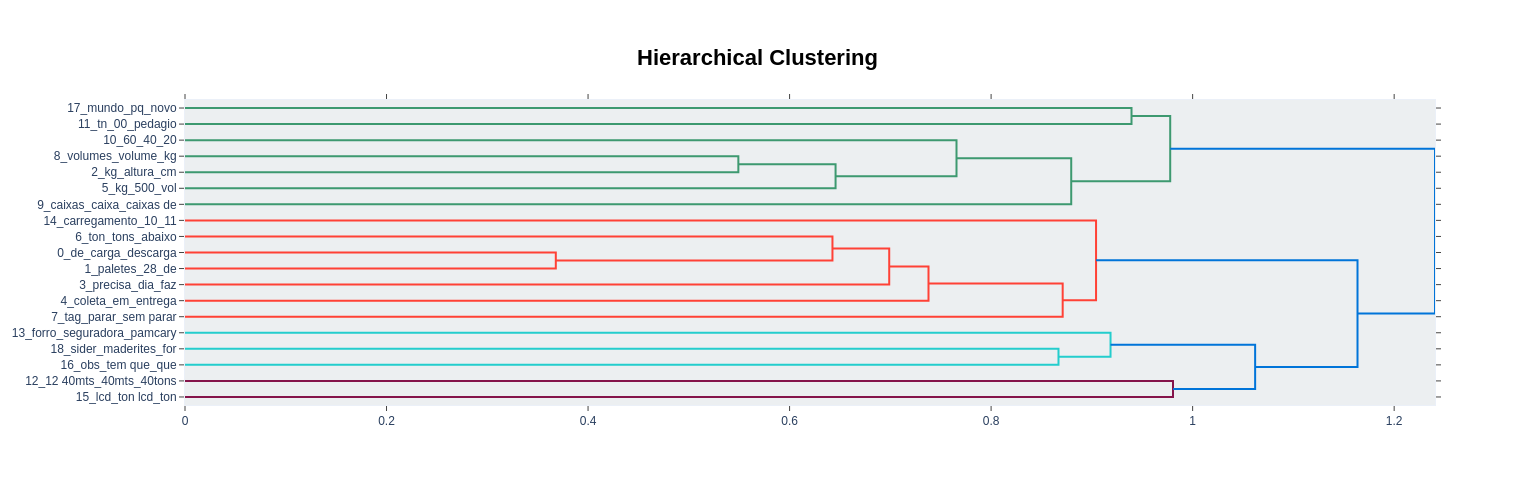

In [71]:
temp_topic_model.visualize_hierarchy(top_n_topics=20)

#### Matrix de similaridade usando heatmap

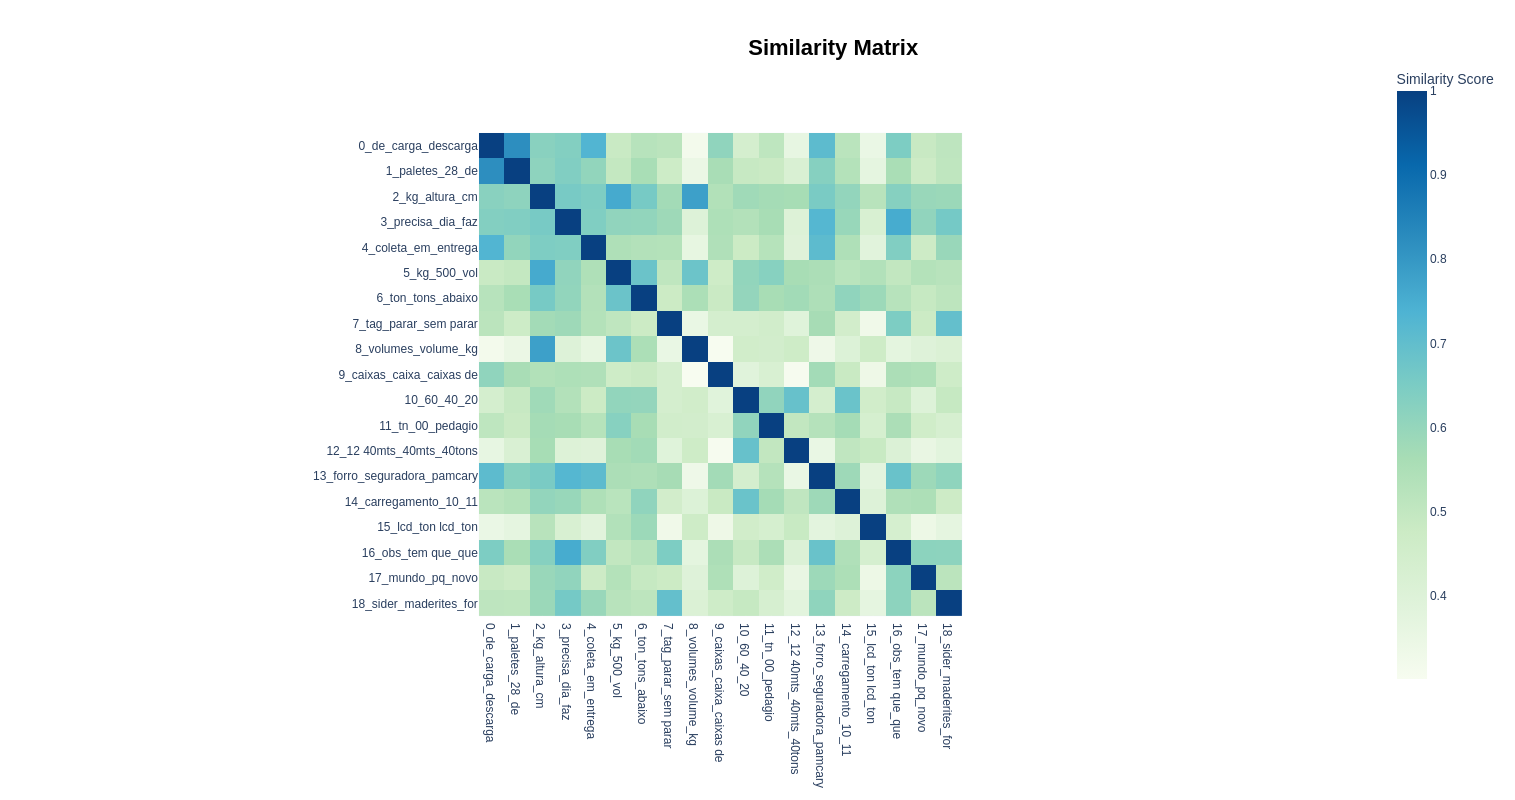

In [72]:
temp_topic_model.visualize_heatmap()

In [73]:
topic_info = temp_topic_model.get_topic_info()

In [74]:
topic_info.to_csv('topic_info_distributions.csv', index=False)

In [75]:
pd.DataFrame({"Document": docs, "Topic": new_topics}).to_csv('topic_distributions.csv', index=False)

### c-tf-idf

In [76]:
temp_topic_model = BERTopic(representation_model=representation_model,
                                embedding_model=bertimbau_embedding,
                                calculate_probabilities=True,
                                n_gram_range=(1, 2),
                                nr_topics=20)

In [77]:
temp_topics, temp_probabilities = temp_topic_model.fit_transform(docs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [78]:
new_topics = temp_topic_model.reduce_outliers(docs, temp_topics, strategy='c-tf-idf')

In [79]:
temp_topic_model.update_topics(docs, topics=new_topics)

2024-02-28 15:06:48,810 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


#### Visualizando as top palavras por tópico

In [80]:
temp_topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1     20  -1_102x93x302_twf 34x99153x7502_twf_roger agrofel   
1       0  20506                          0_de_carga_descarga_livre   
2       1    695                   1_paletes_palete_kg_paletes peso   
3       2    611                                2_kg_vol_buonny_500   
4       3    505                           3_faz_coleta_armazem_arm   
5       4    727                      4_ton_tons_pallets_ton abaixo   
6       5    404                          5_tag_parar_sem parar_sem   
7       6    282                      6_volumes_volume_kg_kg volume   
8       7    429               7_largura_altura_comprimento_medidas   
9       8    324            8_metros_cubicos_cúbicos_metros cúbicos   
10      9    253                  9_caixas_caixa_caixas de_caixa de   
11     10    202                                10_baú_bau_m3_acima   
12     11     36                               11_3t_28ton_pv_40mts   
13     12     86                  12_forro_de forro_pamcary_lona de   
14     13     91                            13_pedagio_00_frete_000   
15     14     20                         14_lcd_ton lcd_ton_kgs lcd   
16     15     94                         15_sider_maderites_ter_for   
17     16    164                           16_carregamento_10_11_18   
18     17    175                        17_mundo_novo mundo_novo_pq   
19     18    152                      18_dia_chamar_chamar no_whats   

                                       Representation  \
0   [102x93x302, twf 34x99153x7502, twf, roger agr...   
1   [de, carga, descarga, livre, em, livre de, car...   
2   [paletes, palete, kg, paletes peso, peso, ton,...   
3   [kg, vol, buonny, 500, 00, 500 kg, kgs, valor ...   
4   [faz, coleta, armazem, arm, armz, carregamento...   
5   [ton, tons, pallets, ton abaixo, abaixo, palle...   
6   [tag, parar, sem parar, sem, tag sem, parar ou...   
7   [volumes, volume, kg, kg volume, kg volumes, 0...   
8   [largura, altura, comprimento, medidas, 20, de...   
9   [metros, cubicos, cúbicos, metros cúbicos, met...   
10  [caixas, caixa, caixas de, caixa de, kg, de, p...   
11  [baú, bau, m3, acima, de, baú de, ou, carreta,...   
12  [3t, 28ton, pv, 40mts, 12 40mts, cod, extensiv...   
13  [forro, de forro, pamcary, lona de, lona, segu...   
14  [pedagio, 00, frete, 000, 000 00, 00 pedagio, ...   
15  [lcd, ton lcd, ton, kgs lcd, lcd 14, lcd embar...   
16  [sider, maderites, ter, for, se, se for, madei...   
17  [carregamento, 10, 11, 18, quarta, 12, 12 carr...   
18  [mundo, novo mundo, novo, pq, pq novo, no pq, ...   
19  [dia, chamar, chamar no, whats, no, no whats, ...   

                                  Representative_Docs  
0   [Preciso de uma Carreta Baú ou Syder para cole...  
1   [4 TON \nLIVRE DE CARGA E DESCARGA E AGENCIAME...  
2   [2,400 KG 2 PALETES, 28 PALETES PESO 18 TON, 3...  
3   [BUONNY * 4 VOLUMES * 24 KG * CUBAGEM : 0,92M³...  
4   [Coleta imediata !, COLETA IMEDIATA., COLETA I...  
5   [8 TON ABAIXO / CHAMAR NO WHATS, 7- TON ABAIXO...  
6   [CARREGAMENTO AMANHA 31/10/2023 / 6 TON / NECE...  
7   [300 kg   6 volumes, 5 KG     1 VOLUME, 3 volu...  
8   [- COMPLEMENTO \n- MEDIDAS: 2,30 LARGURA X 1,2...  
9   [13 metros cúbicos, 13 METROS CÚBICOS, 3 metro...  
10  [COMPLEMENTO - 2 CAIXAS PEQUENAS, 3 caixas peq...  
11  [- CARRETA SOMENTE DE 105M3 PARA CIMA\n- VEÍCU...  
12   [Extensiva  24mts, 20PL 28TON, PV 26937 e 26936]  
13  [SEGURADORA  PAMCARY  OU  KRONA  \nNESCESSARIO...  
14  [FRETE- R$- 5.500,00 + PEDAGIO-  SOMENTE SIDER...  
15             [50 TON LCD, 25 TON LCD, +-20 ton lcd]  
16  [sider necessario maderites, SIDER NECESSARIO ...  
17  [Carregamento 29/11 - quarta*\nCarregamento 29...  
18  [OBS... VALOR R$400,00 | 500KG | 25 VOL | CARR...  
19  [Descarga 09/11 / 21  tom abaixo / chamar no W...

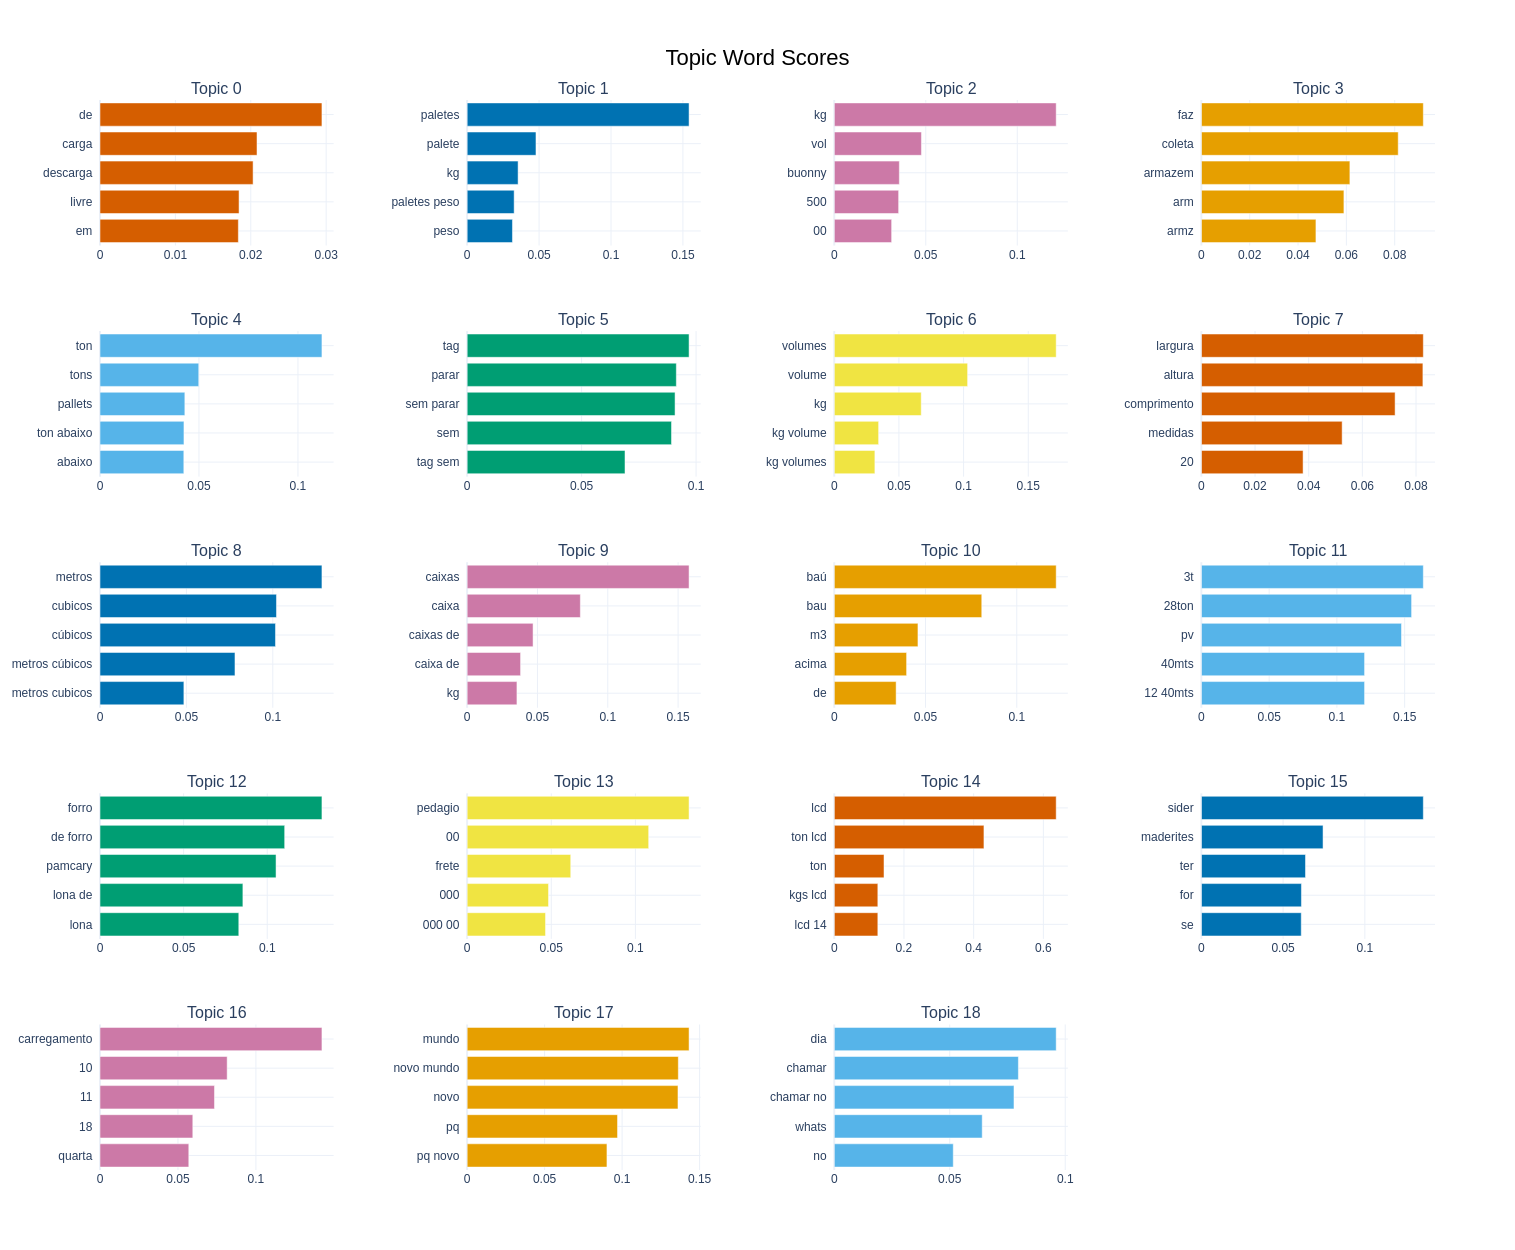

In [81]:
temp_topic_model.visualize_barchart(top_n_topics=20)


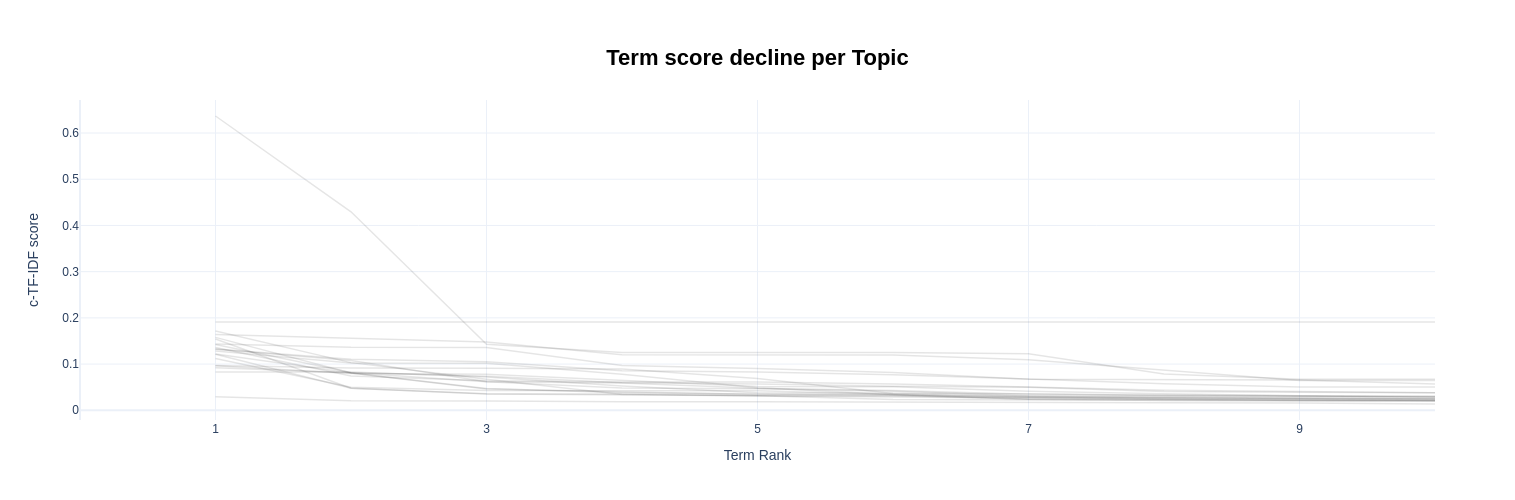

In [82]:
temp_topic_model.visualize_term_rank()

#### Visualizando a distância entre os tópicos

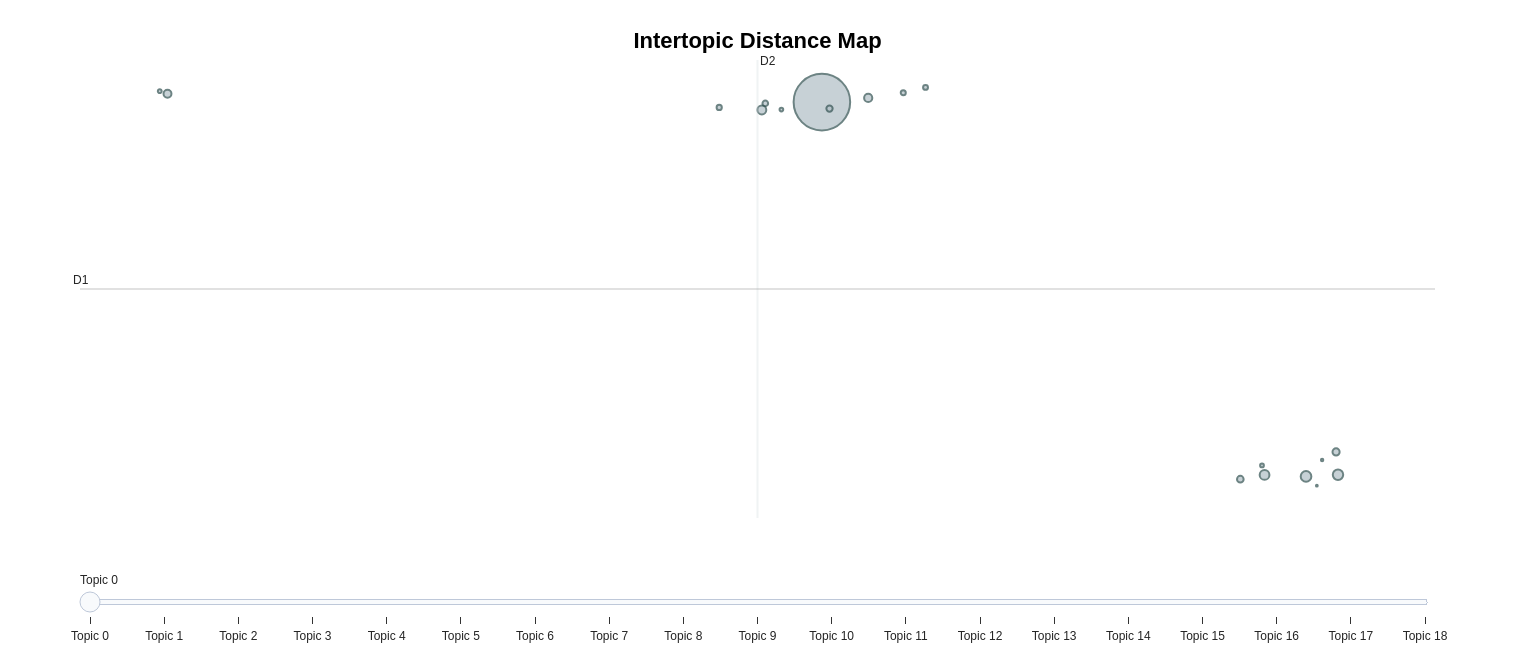

In [83]:
temp_topic_model.visualize_topics()

#### Vizualiando as conexões entre os tópicos

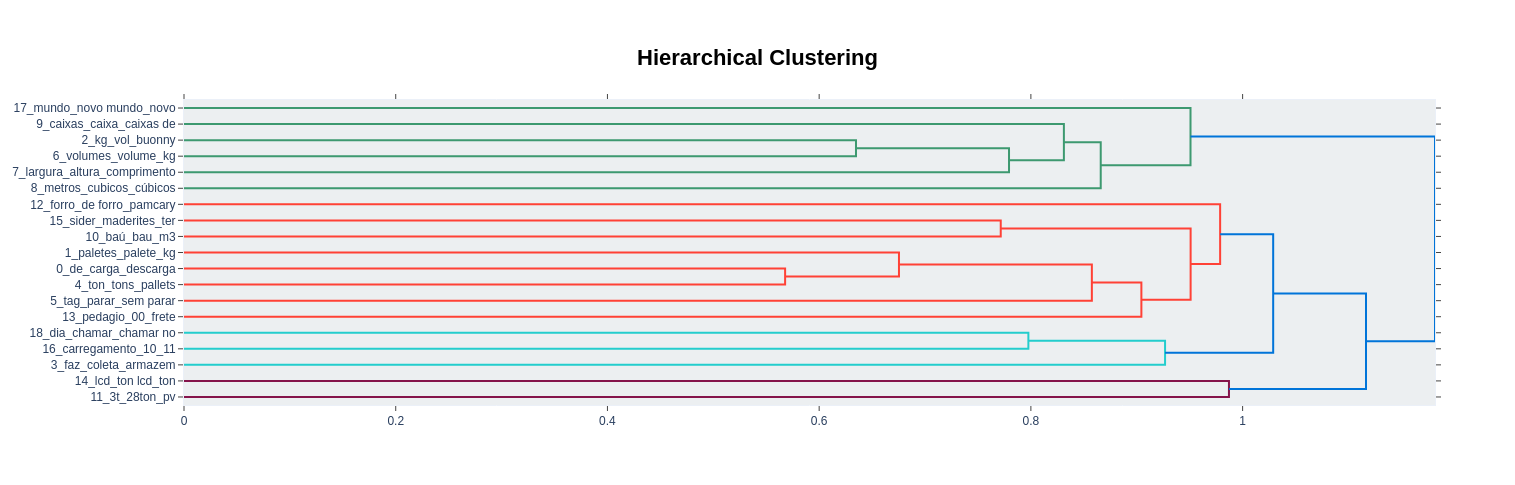

In [84]:
temp_topic_model.visualize_hierarchy(top_n_topics=20)

#### Matrix de similaridade usando heatmap

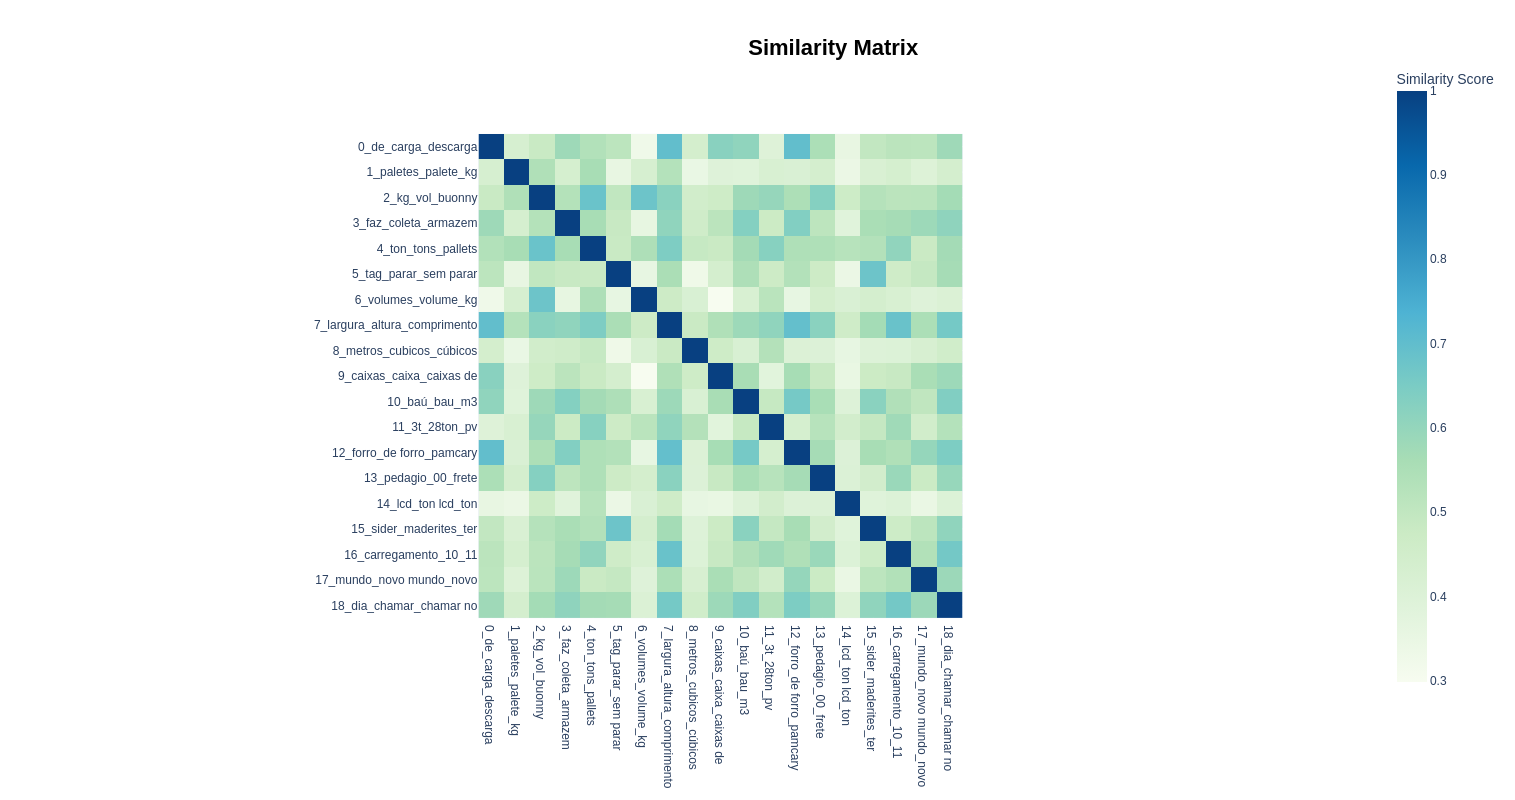

In [85]:
temp_topic_model.visualize_heatmap()

In [86]:
topic_info = temp_topic_model.get_topic_info()

In [87]:
topic_info.to_csv('topic_info_c-tf-idf.csv', index=False)

In [88]:
pd.DataFrame({"Document": docs, "Topic": new_topics}).to_csv('topic_c-tf-idf.csv', index=False)

### embeddings

In [89]:
temp_topic_model = BERTopic(representation_model=representation_model,
                                embedding_model=bertimbau_embedding,
                                calculate_probabilities=True,
                                n_gram_range=(1, 2),
                                nr_topics=20)

In [90]:
temp_topics, temp_probabilities = temp_topic_model.fit_transform(docs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [91]:
new_topics = temp_topic_model.reduce_outliers(docs, temp_topics, strategy='embeddings')

In [92]:
temp_topic_model.update_topics(docs, topics=new_topics)

2024-02-28 15:19:15,349 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


#### Visualizando as top palavras por tópico

In [93]:
temp_topic_model.get_topic_info()

Topic  Count                                               Name  \
0       0  20160                             0_de_carga_descarga_em   
1       1   1819                              1_paletes_de_carga_28   
2       2    904                               2_kg_volumes_vol_kgs   
3       3    489                          3_tag_parar_sem parar_sem   
4       4    356               4_medidas_altura_largura_comprimento   
5       5    570                           5_coleta_arm_armazem_faz   
6       6    524                             6_peso_ton_kg_ton peso   
7       7    169                          7_pallets_pallet_tons_ton   
8       8    148                        8_caixas_caixa_kg_caixas de   
9       9     58  9_cargill_desempenho código_alto desempenho_de...   
10     10     99                               10_baú_bau_baú de_m3   
11     11    102                11_academia_de academia_krona_forro   
12     12    107          12_carregamento_10_11_quarta carregamento   
13     13     56                      13_pv_tn_pix necessário_truck   
14     14     18                          14_lcd_ton lcd_ton_lcd 14   
15     15     49                      15_roteiro_km_sentido_fazenda   
16     16     74                          16_00_valor_obs valor_vol   
17     17     33                   17_china_obs_pra eraldo_ou china   
18     18     41       18_sider_maderites_maderite_sider necessario   

                                       Representation  \
0   [de, carga, descarga, em, livre, livre de, car...   
1   [paletes, de, carga, 28, livre, 28 paletes, de...   
2   [kg, volumes, vol, kgs, volume, cubicos, buonn...   
3   [tag, parar, sem parar, sem, tag sem, ter, buo...   
4   [medidas, altura, largura, comprimento, 20, 40...   
5   [coleta, arm, armazem, faz, armz, carregamento...   
6   [peso, ton, kg, ton peso, volumes, total, peso...   
7   [pallets, pallet, tons, ton, 20, 24, 00, 24 pa...   
8   [caixas, caixa, kg, caixas de, caixa de, cm, d...   
9   [cargill, desempenho código, alto desempenho, ...   
10  [baú, bau, baú de, m3, de, sider, de 105m3, 10...   
11  [academia, de academia, krona, forro, de forro...   
12  [carregamento, 10, 11, quarta carregamento, ca...   
13  [pv, tn, pix necessário, truck, 14, carreta mi...   
14  [lcd, ton lcd, ton, lcd 14, kgs lcd, 500kg lcd...   
15  [roteiro, km, sentido, fazenda, fertipar, agen...   
16  [00, valor, obs valor, vol, mundo, novo, novo ...   
17  [china, obs, pra eraldo, ou china, eraldo ou, ...   
18  [sider, maderites, maderite, sider necessario,...   

                                  Representative_Docs  
0   [12 TON. LIVRE DE CARGA E DESCARGA., livre de ...  
1   [10,3 ton 14 paletes / livre de carga e descar...  
2   [BUONNY * 7 VOLUMES * 20 KG * CUBAGEM : 1,48M³...  
3   [+ Pedágio no TAG sem parar., CARREGAMENTO LIB...  
4   [- COMPLEMENTO \n- MEDIDAS: 2,30 DE COMPRIMENT...  
5   [Coleta IMEDIATA, Coleta imediata !, COLETA IM...  
6   [PESO 6-TON, peso 4 a 6 ton, 04 volumes\nPeso_...  
7   [24 PALLETS 27,7 TONS., 4 PALLETS 5 TONS, Equi...  
8   [COMPLEMENTO - 2 CAIXAS PEQUENAS, 4 caixas., 3...  
9   [CARGA DE ALTO DESEMPENHO. Código: 44161, CARG...  
10  [Baú de 105m3  ou MAIOR, Baú de 105m3, - CARRE...  
11  [SEGURADORA  PAMCARY  OU  KRONA  \nNESCESSARIO...  
12  [*Carregamento 01/11 - quarta*\n*Carregamento ...  
13  [30tons 28pallets., Extensiva  24mts, 20PL 28TON]  
14             [50 TON LCD, +-20 ton lcd, 25 TON LCD]  
15  [CARREGAMENTO ARMZ FERTIPAR\nRoteiro:2º Santa ...  
16  [OBS... VALOR R$400,00 | 500KG | 25 VOL | CARR...  
17  [SEGURADORA BOUNNY ADIANTAMENTO DE 80%  OBS O ...  
18  [sider necessario maderites, SIDER NECESSARIO ...

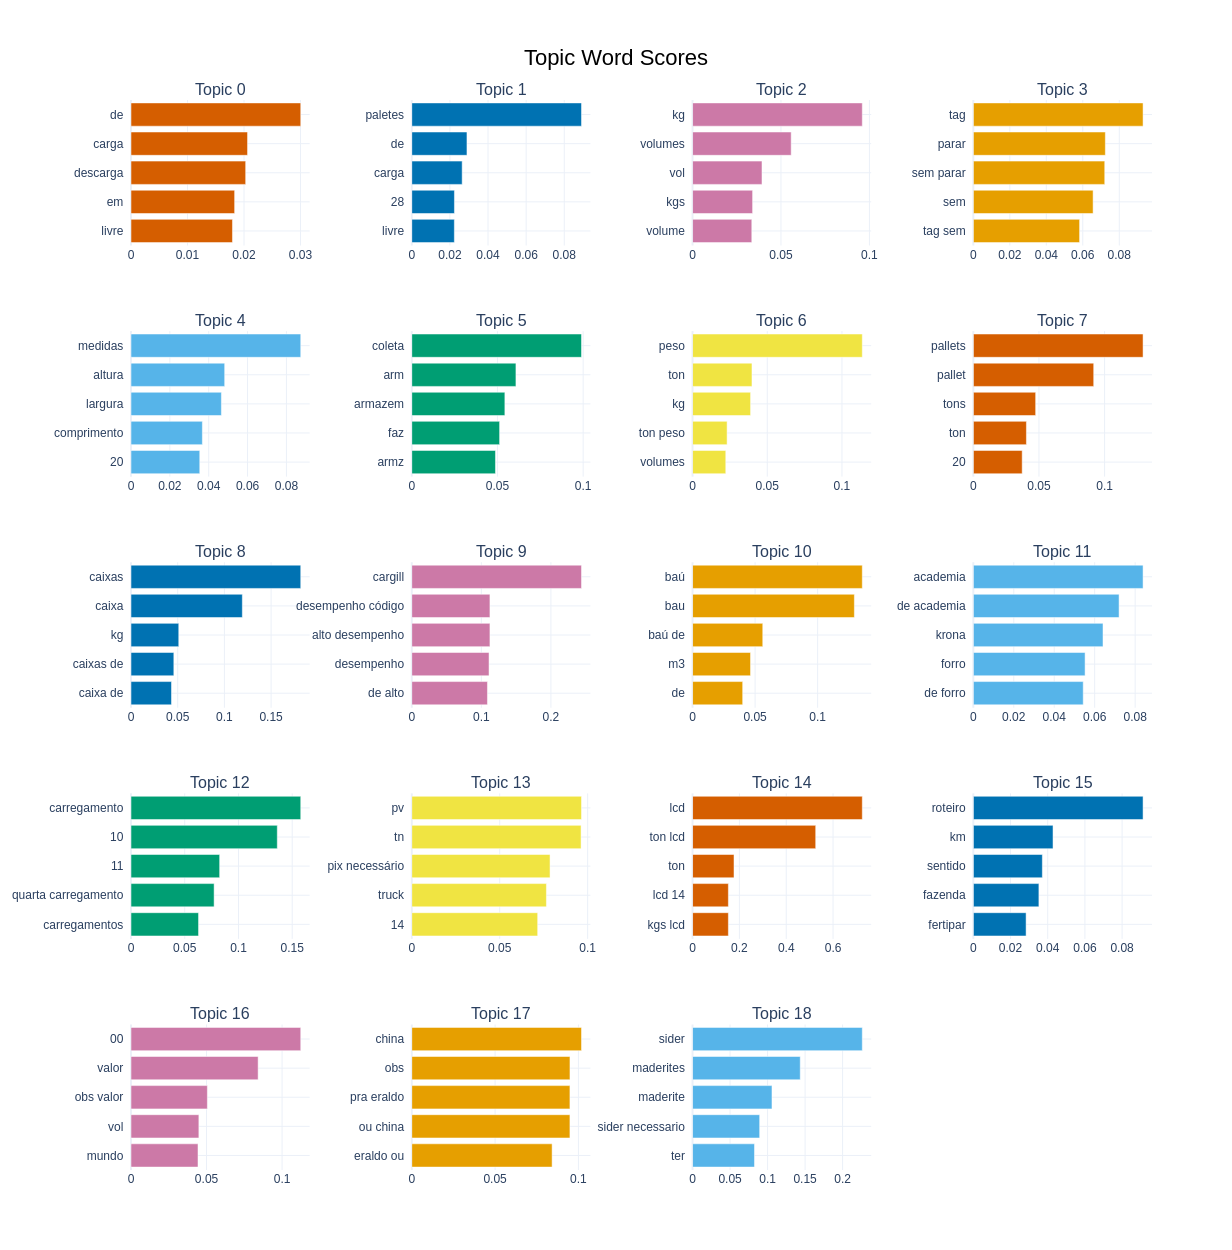

In [94]:
temp_topic_model.visualize_barchart(top_n_topics=20)

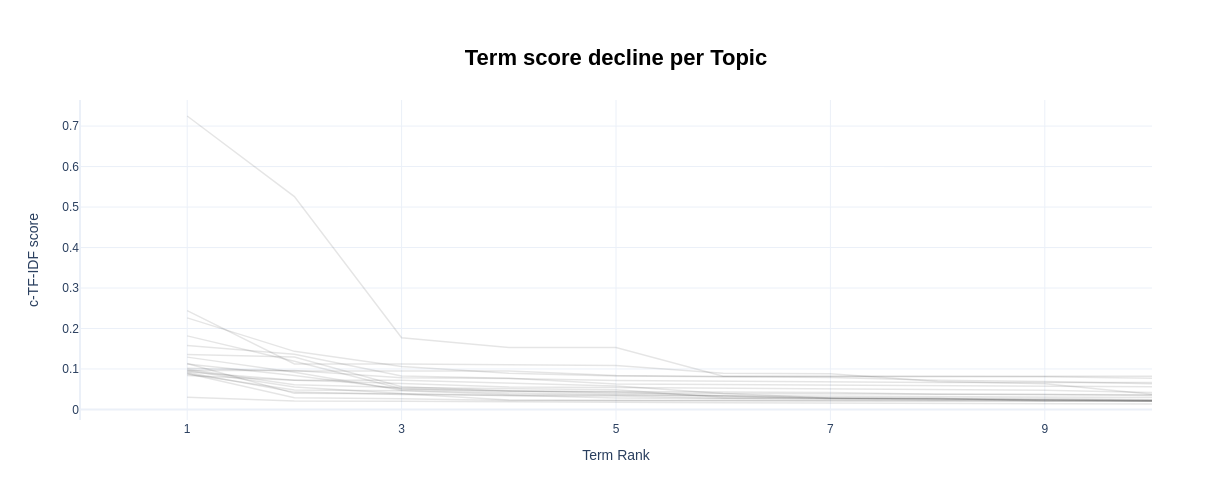

In [95]:
temp_topic_model.visualize_term_rank()

#### Visualizando a distância entre os tópicos

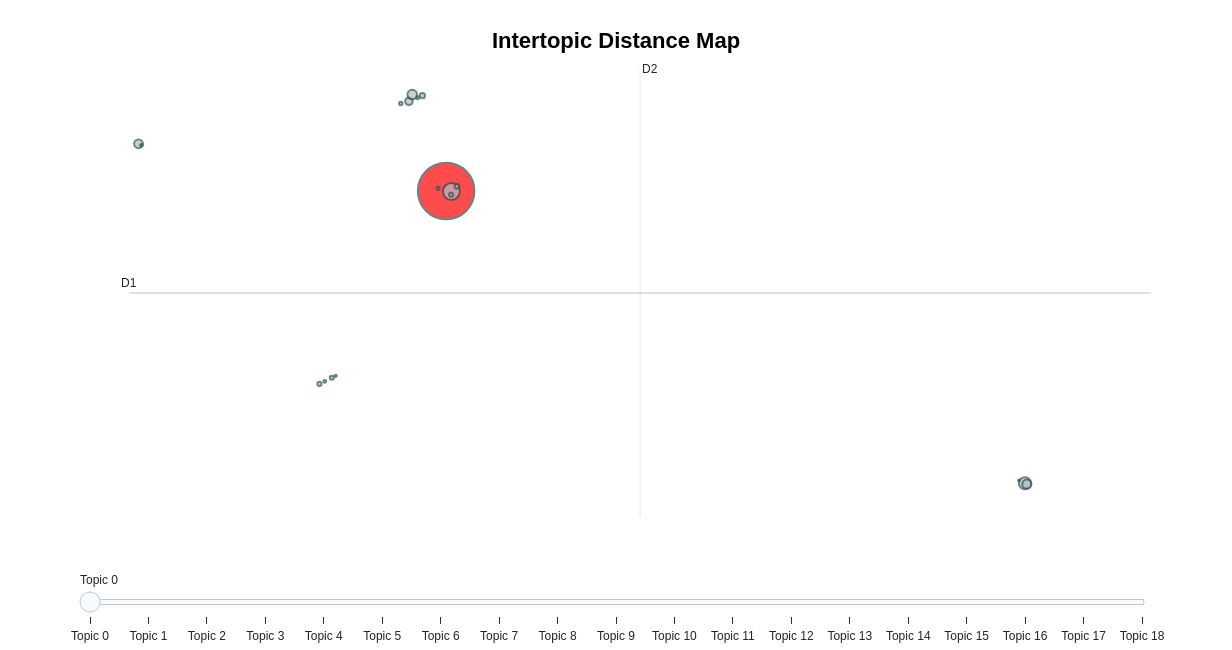

In [96]:
temp_topic_model.visualize_topics()

#### Vizualiando as conexões entre os tópicos

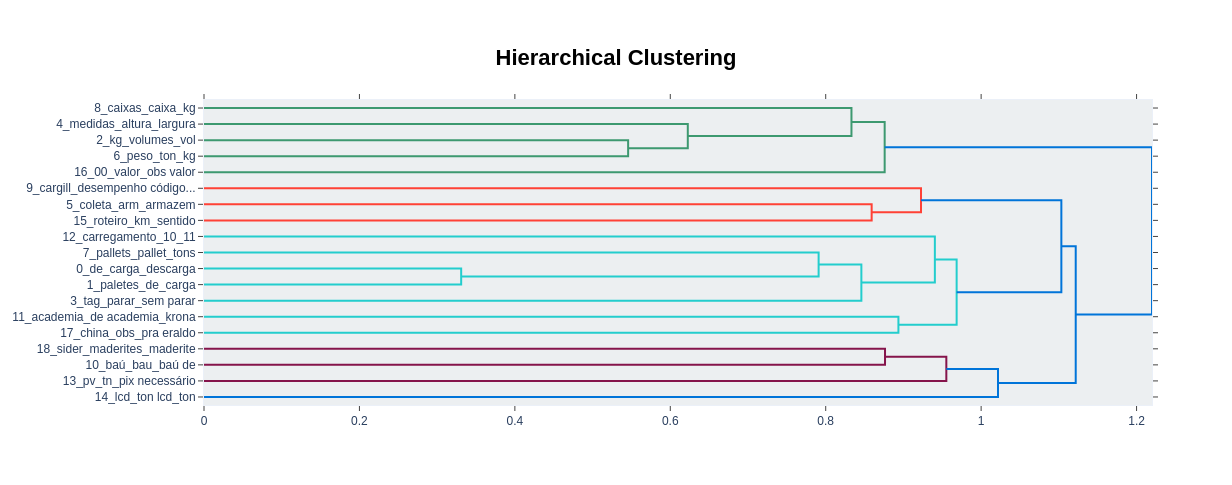

In [97]:
temp_topic_model.visualize_hierarchy(top_n_topics=20)

#### Matrix de similaridade usando heatmap

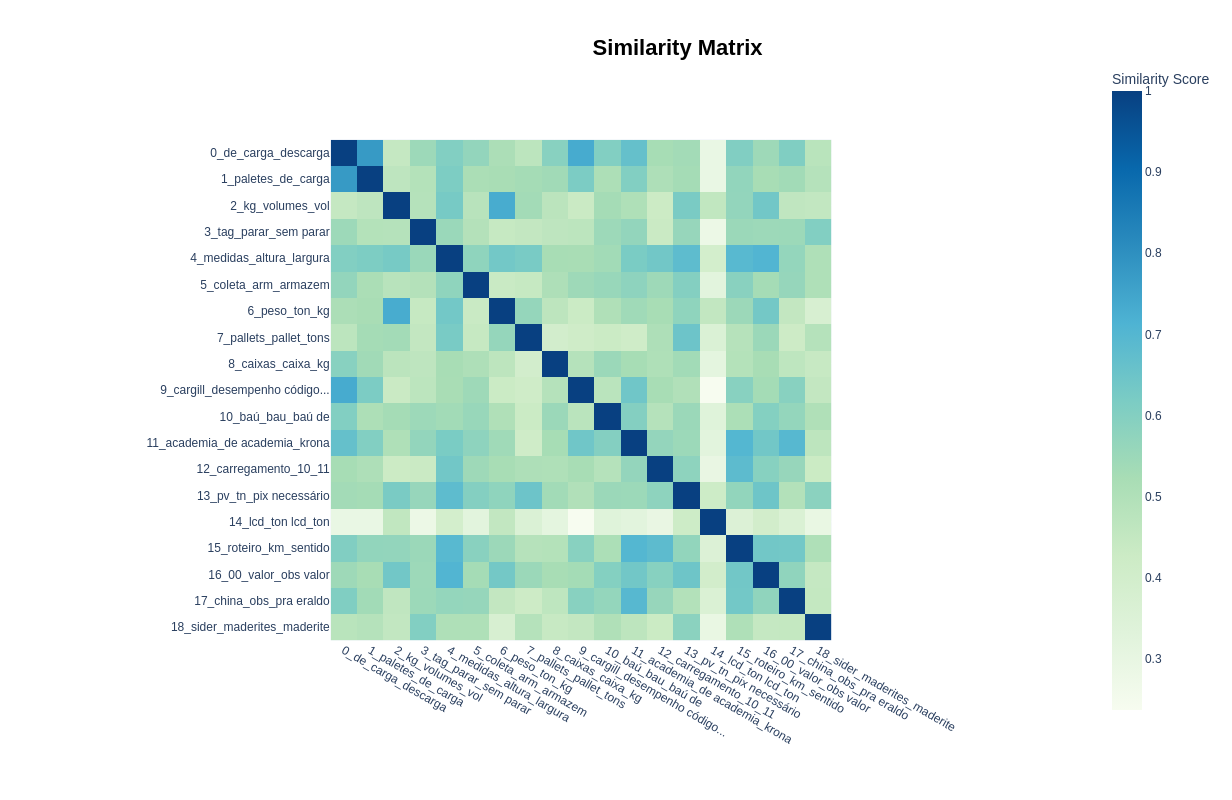

In [98]:
temp_topic_model.visualize_heatmap()

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

In [ ]:
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

In [99]:
topic_info = temp_topic_model.get_topic_info()

In [100]:
topic_info.to_csv('topic_info_embeddings.csv', index=False)

In [101]:
pd.DataFrame({"Document": docs, "Topic": new_topics}).to_csv('topic_info_embeddings.csv', index=False)

In [ ]:
temp_topic_model.save("embedding_outlier_reduction", serialization="pytorch", save_ctfidf=True, save_embedding_model=embedding_model)

In [111]:
temp_probabilities

array([[3.76782175e-001, 1.69191485e-002, 1.29183723e-002, ...,
        9.47342767e-004, 3.36190374e-004, 8.15889576e-004],
       [5.64335415e-001, 1.52541637e-002, 1.11420303e-002, ...,
        7.58686333e-004, 3.69470177e-004, 3.11679260e-003],
       [3.17476016e-001, 7.95548601e-003, 5.84245987e-003, ...,
        4.01564752e-004, 2.15108146e-004, 1.04710445e-003],
       ...,
       [3.10082539e-001, 8.93233012e-003, 6.60472056e-003, ...,
        4.66938062e-004, 2.47116726e-004, 9.72557298e-004],
       [1.00000000e+000, 7.38015789e-306, 5.06747178e-306, ...,
        4.41584888e-307, 1.72208860e-307, 4.80254651e-307],
       [1.39364318e-304, 6.62227468e-306, 8.65446431e-306, ...,
        3.54907527e-307, 1.88211460e-307, 4.30329668e-307]])

In [112]:
doc_id = np.argmin(np.max(temp_probabilities, axis=1))

In [114]:
print(f"Probabilidades: {temp_probabilities[doc_id]}")

Probabilidades: [1.87079782e-05 1.91028782e-06 8.76230880e-07 3.83395168e-07
 3.40081083e-07 2.97847590e-07 2.28887184e-07 1.66783054e-07
 1.76020513e-07 1.14324454e-07 1.07976776e-07 1.07774294e-07
 1.12565375e-07 5.49916705e-08 5.64302706e-08 6.55099045e-08
 6.15109668e-08 4.41243522e-08 5.39973408e-08]


In [115]:
docs[doc_id]

'************************************** CARREGO HOJE/AGORA ******************\n6TON\n3 ENTREGAS\nOBRIGATORIO LONA ISERADA, LONA PARA ASOALHO E CORDAS\nSIDER OBRIGATORIO MADEIRITES PARA AS LATERAIS\n***************************** CARREGO HOJE/AGORA ****************************'

### Reduzir topicos

In [ ]:
temp_topic_model.reduce_topics(docs, nr_topics=10)

In [ ]:
topics = topic_model.topics_

### Mergear topicos

In [ ]:
topics_to_merge = [1, 2]
topic_model.merge_topics(docs, topics_to_merge)

documentos com entropia alta têm probabilidades mais uniformemente distribuídas entre vários tópicos

In [112]:
doc_id = np.argmin(np.max(temp_probabilities, axis=1))

In [114]:
print(f"Probabilidades: {temp_probabilities[doc_id]}")

Probabilidades: [1.87079782e-05 1.91028782e-06 8.76230880e-07 3.83395168e-07
 3.40081083e-07 2.97847590e-07 2.28887184e-07 1.66783054e-07
 1.76020513e-07 1.14324454e-07 1.07976776e-07 1.07774294e-07
 1.12565375e-07 5.49916705e-08 5.64302706e-08 6.55099045e-08
 6.15109668e-08 4.41243522e-08 5.39973408e-08]


In [115]:
docs[doc_id]

'************************************** CARREGO HOJE/AGORA ******************\n6TON\n3 ENTREGAS\nOBRIGATORIO LONA ISERADA, LONA PARA ASOALHO E CORDAS\nSIDER OBRIGATORIO MADEIRITES PARA AS LATERAIS\n***************************** CARREGO HOJE/AGORA ****************************'

In [116]:
entropias = [-np.sum(p * np.log(p + 1e-9) for p in probabilidades) for probabilidades in temp_probabilities]

/tmp/ipykernel_7171/2255127557.py:1: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.



In [117]:
indices_docs_maior_entropia = np.argsort(entropias)[-50:]

In [120]:
docs_maior_entropia = [docs[i] for i in indices_docs_maior_entropia]

In [121]:
docs_maior_entropia

['01 MAQUINA USADA --- MEDIDAS 2.26 LARGURA X 4.10 COMPRIMENTO X 2.82 ALTURA',
 'vol 215\nkg 995\n15,50 M³',
 '2,20m³  20 caixas de 60 x 46 x 40',
 'metragem: 6 chapas 3,00x1200x3000mm',
 '2 VOLUMES\n\nMEDIDAS: 5CM X 5CMX 1,00M\n\n4CM X 30CM X 50CM',
 'Buonny ativa  2 volumes de 1,70x0,50x0,65',
 'C O M P L E M E N T O   \nMEDIDAS: 2,00 X 0,70 X 1,95',
 '2 CAIXAS DE 1.40X0.90X2.00 Metros.',
 '98 VOLUMES - 1049 KG - MEDIDAS: 0,50 X 0,50 X 0,50 = 17.00 M³',
 '1 VOLUME: 1200x900x1600MM\n2 VOLUMES: 1300x1440x1600MM\n1 VOLUME: 1300x1440x1600MM\n2 VOLUMES: 700x700x500MM\n1 VOLUME: 1150x700x500MM',
 '06 Rolos – Medidas 2,10x2,10x0,35\n01 Rolo – Medidas 1,90x1,90x0,30\nPeso total 470 Kg',
 '40 VOL  =   0,50 x 0,40 x 0,35  ( cada )   = 180kg \nTER BUONNY LIBERADA',
 '2 pre quadros 2,5 x 2 x 1 altura 300 quilos os dois',
 'Medidas: \n2,30 de comprimento x 1,50 de altura x 1,20 de largura\n2,30 de comprimento x 1,50 de altura x 0,40 de largura\n1,64 de comprimento x 1,30 de altura x 1,20 de largu

In [122]:
variancias = np.var(temp_probabilities, axis=1)

In [123]:
indices_docs_menor_variancia = np.argsort(variancias)[:50]

In [124]:
docs_menor_variancia = [docs[i] for i in indices_docs_menor_variancia]

In [125]:
docs_menor_variancia

['************************************** CARREGO HOJE/AGORA ******************\n6TON\n3 ENTREGAS\nOBRIGATORIO LONA ISERADA, LONA PARA ASOALHO E CORDAS\nSIDER OBRIGATORIO MADEIRITES PARA AS LATERAIS\n***************************** CARREGO HOJE/AGORA ****************************',
 '***************** CARREGO HOJE/AGORA **************\n48Ton \nOBRIGATORIO LONA ISERDA, LONA PARA ASOALHO E CORDAS\nSIDER OBRIGATORIO MADEIRITES PARA AS LATERAIS\n************** CARREGO HOJE/AGORA ***********',
 '************************** CARREGO HOJE/AGORA ***********************\n15Ton\nOBRIGATORIO LONA ISERADA, LONA PARA ASOALHO E CORDAS\nSIDER OBRIGATORIO MADEIRITES PARA AS LATERAIS\n************************** CARREGO HOJE/AGORA ***************************',
 '************************ CARREGO HOJE ***********************\n15Ton\n3ENTREGAS\nOBRIGATORIO LONA ISERADA, LONA PARA ASOALHO E CORDAS\nSIDER OBRIGATORIO MADEIRITES PARA AS LATERAIS\n********************* CARREGO HOJE **********************',
 '*******